In [1]:
import os
import time
import json
import warnings
import pickle
import requests
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from gurobipy import *

from functions import *

# Simulation of 8 banks with payment values following a lognormal distribution (mu = 1, std = 20%, max = 10mu)

In [2]:
# Inputs
# data generation
num_payments = [5, 10, 20, 50, 100, 300]
mu = 1000000
sigma = 0.2
val_max = 10*mu

num_banks = 8
start_time = datetime.now().replace(hour=8, minute=0, second=0, microsecond=0)
end_time = start_time.replace(hour=18)

currency_dict = {
    0: [['GBP', 'USD'], [0.5, 0.5]],
    1: [['GBP', 'USD'], [0.5, 0.5]],
    2: [['GBP', 'USD'], [0.5, 0.5]],
    3: [['GBP', 'USD'], [0.5, 0.5]],
    4: [['GBP', 'USD'], [0.5, 0.5]],
    5: [['GBP', 'USD'], [0.5, 0.5]],
    6: [['GBP', 'USD'], [0.5, 0.5]],
    7: [['GBP', 'USD'], [0.5, 0.5]],
}

receiver_dict_USD = {
    0: [[0, 1, 2, 3, 4, 5, 6, 7], [0.0, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]],
    1: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 0.0, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]],
    2: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 0.0, 1/7, 1/7, 1/7, 1/7, 1/7]],
    3: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 1/7, 0.0, 1/7, 1/7, 1/7, 1/7]],
    4: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 1/7, 1/7, 0.0, 1/7, 1/7, 1/7]],
    5: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 1/7, 1/7, 1/7, 0.0, 1/7, 1/7]],
    6: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0.0, 1/7]],
    7: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0.0]],
}

receiver_dict_GBP = {
    0: [[0, 1, 2, 3, 4, 5, 6, 7], [0.0, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]],
    1: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 0.0, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]],
    2: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 0.0, 1/7, 1/7, 1/7, 1/7, 1/7]],
    3: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 1/7, 0.0, 1/7, 1/7, 1/7, 1/7]],
    4: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 1/7, 1/7, 0.0, 1/7, 1/7, 1/7]],
    5: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 1/7, 1/7, 1/7, 0.0, 1/7, 1/7]],
    6: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0.0, 1/7]],
    7: [[0, 1, 2, 3, 4, 5, 6, 7], [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0.0]],
}

receiver_dict= {'USD': receiver_dict_USD, 'GBP': receiver_dict_GBP}

values_dict = {
    0: [mu, sigma, val_max],
    1: [mu, sigma, val_max],
    2: [mu, sigma, val_max],
    3: [mu, sigma, val_max],
    4: [mu, sigma, val_max],
    5: [mu, sigma, val_max],
    6: [mu, sigma, val_max],
    7: [mu, sigma, val_max],
}

rate_dict = {
    "USD/USD": 1.0,
    "GBP/USD": 1.2
}

# MILP
frequency='1H'
alternate = True
verbose = False
cycle_percentage = 90
initial_percentage = 100

# processor
num_days = 100
attempts = [
    {"IntFeasTol": 1e-9, "cycle_balance_percentage": 90, "time_limit": 120},
    {"IntFeasTol": 1e-9, "cycle_balance_percentage": 95, "time_limit": 120},
    {"IntFeasTol": 1e-5, "cycle_balance_percentage": 100, "time_limit": 120}
        ]
decimal=2
threads=4
processes=50
sim = 'sim5-delay'

In [3]:
rds_base = os.getenv('RDS')
results = []

sim_start_time = time.time()

for n in num_payments:
    lamb = get_lamb(n, time_period=3600)
    lambda_dict = {0: lamb, 1: lamb, 2: lamb, 3: lamb, 4: lamb, 5: lamb, 6: lamb, 7: lamb}
    senario = f"{n}_payments"
    os.makedirs(f'{rds_base}/home/{sim}/{senario}', exist_ok=True)
    log_file_path = f'{rds_base}/home/{sim}/log_file.txt'
    setup_logging(log_file_path)
    print(f'scenario: {n}')
    result = test_processor(sim, num_days, num_banks, start_time, end_time, lambda_dict, currency_dict, values_dict, rate_dict, receiver_dict, 
                            frequency, alternate, verbose, cycle_percentage, initial_percentage, senario, attempts, decimal, threads, processes, min_delay=True)
    results.append(result)

scenario: 5


No system rejections. Simulation completed successfully with initial percentage: 100
scenario: 10


No system rejections. Simulation completed successfully with initial percentage: 100
scenario: 20


No system rejections. Simulation completed successfully with initial percentage: 100
scenario: 50


No system rejections. Simulation completed successfully with initial percentage: 100
scenario: 100


No system rejections. Simulation completed successfully with initial percentage: 100
scenario: 300


No system rejections. Simulation completed successfully with initial percentage: 100


In [4]:
print(f'Running time {time.time() - sim_start_time}')

Running time 13391.166727781296


In [5]:
all_results = []
participant_results = []

for n, (system_df, participant_dfs) in zip(num_payments, results):
    system_df['number_of_payments'] = n
    all_results.append(system_df)
    for participant, participant_df in participant_dfs.items():
        participant_df['number_of_payments'] = n
        participant_df['participant'] = participant
        participant_results.append(participant_df)
combined_results = pd.concat(all_results)
combined_participant_results = pd.concat(participant_results)
rds_base = os.getenv('RDS')
with open(fr'{rds_base}/home/{sim}/system_results.pkl', 'wb') as f:
    pickle.dump(combined_results, f)
with open(fr'{rds_base}/home/{sim}/participant_results.pkl', 'wb') as f:
    pickle.dump(combined_participant_results, f)

In [6]:
rds_base = os.getenv('RDS')
combined_results = load_from_pickle(fr'{rds_base}/home/{sim}/system_results.pkl')
combined_results['diff_liquidity_needed_B'] = [[b - a for a, b in zip(row['MILP_cycle_liquidity_needed_list_B'], row['naive_cycle_liquidity_needed_list_B'])] for _, row in combined_results.iterrows()]
combined_results['avg_cycle_running_time'] = combined_results['attempt_duration'].apply(calculate_average_of_nested_lists)
combined_results_participant = load_from_pickle(fr'{rds_base}/home/{sim}/participant_results.pkl')
combined_results_participant['diff_liquidity_needed_B'] = [[b - a for a, b in zip(row['MILP_cycle_liquidity_needed_list_B'], row['naive_cycle_liquidity_needed_list_B'])] for _, row in combined_results_participant.iterrows()]

Distribution of cycle liqudity needed (5 payments): 
    0.00         6777.08      20380.11     23861.62     65513.80     \
0           15            0            1            0            0   
1            3            0            0            0            0   
2            6            0            0            1            0   
3            0            0            0            0            0   
4            1            0            0            0            1   
5            0            0            0            0            0   
6            0            0            0            0            0   
7            0            1            0            0            0   
8            0            0            0            0            0   
9            0            0            0            0            0   

   85080.97     86537.97     86622.48     106247.57    121994.02    ...  \
0            0            0            0            0            0  ...   
1            0           

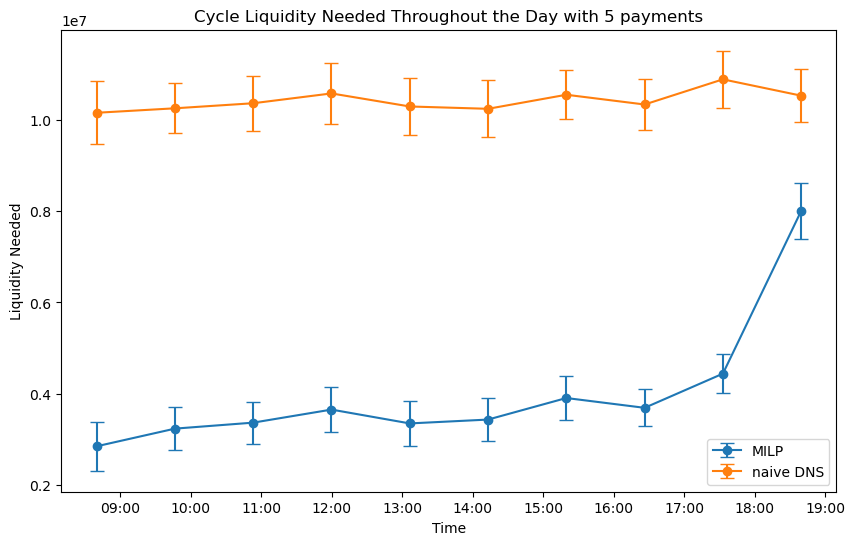

Distribution of cycle liqudity needed (5 payments, bank 0): 
    0.000000e+00  1.421085e-14  6.572000e+01  1.027300e+02  1.064200e+02  \
0            76             0             0             0             0   
1            65             0             0             0             0   
2            57             0             0             0             0   
3            59             0             0             0             1   
4            58             0             0             0             0   
5            56             0             1             0             0   
6            55             0             0             0             0   
7            54             1             0             0             0   
8            46             0             0             0             0   
9            52             0             0             1             0   

   1.078600e+02  1.133500e+02  1.161600e+02  1.539200e+02  2.501100e+02  ...  \
0             0             0   

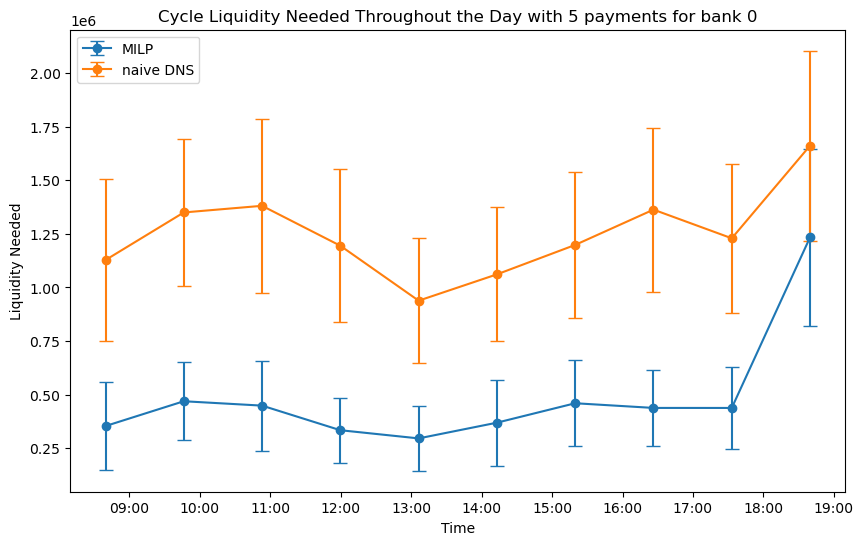

Distribution of cycle liqudity needed (5 payments, bank 1): 
    -0.000000e+00   3.637979e-12   4.042000e+01   1.647200e+02   2.017900e+02  \
0             75              0              0              0              0   
1             71              0              0              0              0   
2             69              0              0              0              0   
3             60              0              0              0              0   
4             54              0              0              0              0   
5             51              0              0              1              0   
6             56              0              1              0              0   
7             56              1              0              0              1   
8             52              0              0              0              0   
9             57              0              0              0              0   

    3.861400e+02   6.310100e+02   1.281020e+03   1.750560

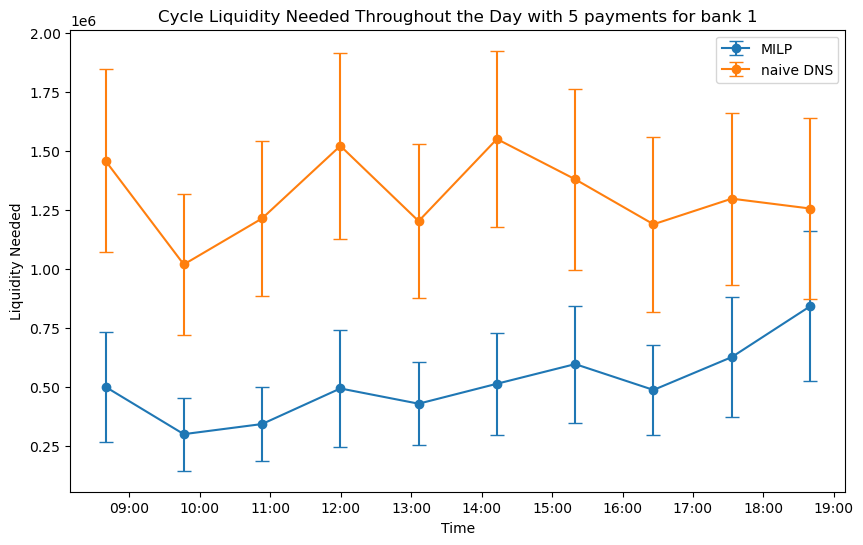

Distribution of cycle liqudity needed (5 payments, bank 2): 
    -0.000000e+00   3.637979e-12   6.548362e-11   1.274000e+01   2.529000e+01  \
0             75              0              0              0              0   
1             61              0              0              0              0   
2             59              0              0              0              0   
3             55              0              1              0              0   
4             53              1              0              0              0   
5             55              0              0              1              0   
6             48              0              0              0              0   
7             52              0              0              0              1   
8             48              0              0              0              0   
9             40              0              0              0              0   

    3.129000e+01   3.513000e+01   3.930000e+01   7.437000

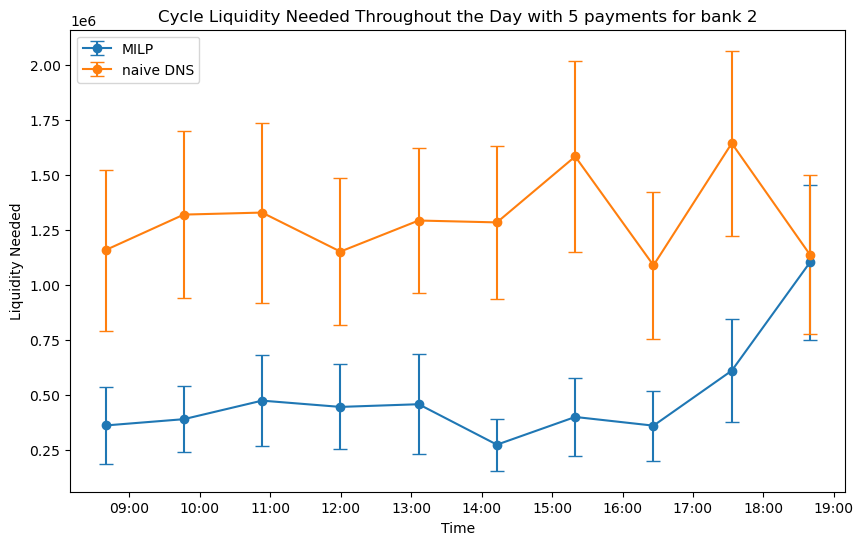

Distribution of cycle liqudity needed (5 payments, bank 3): 
    -0.000000e+00   3.492460e-10   1.130000e+01   1.225000e+02   2.593800e+02  \
0             75              0              0              0              0   
1             62              0              0              0              0   
2             69              0              0              0              0   
3             60              0              0              0              0   
4             58              0              0              0              0   
5             48              1              0              0              0   
6             51              0              0              0              0   
7             57              0              0              0              1   
8             57              0              0              1              0   
9             59              0              1              0              0   

    6.607000e+02   9.873700e+02   1.020690e+03   1.302820

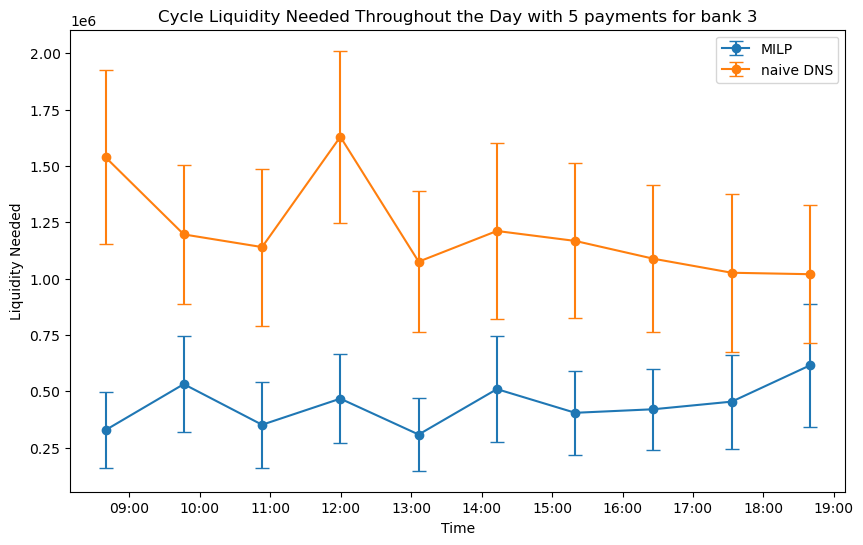

Distribution of cycle liqudity needed (5 payments, bank 4): 
    -0.000000e+00   7.389644e-13   1.818989e-11   2.793854e-11   1.127773e-10  \
0             77              0              0              0              0   
1             66              0              1              0              0   
2             62              0              0              0              0   
3             62              0              0              1              0   
4             64              0              0              0              1   
5             59              0              0              0              0   
6             45              0              0              0              0   
7             51              0              0              0              0   
8             48              1              0              0              0   
9             46              0              0              0              0   

    7.500000e-01   2.010000e+00   2.540000e+00   1.293000

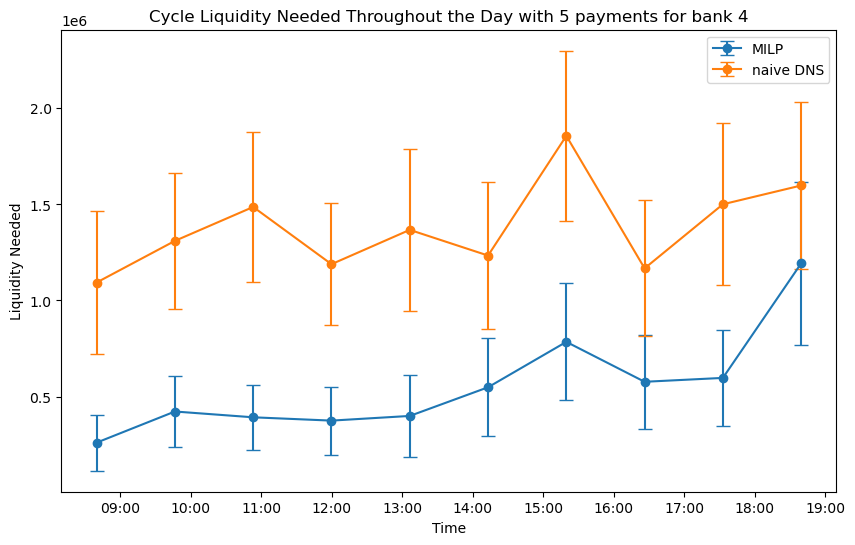

Distribution of cycle liqudity needed (5 payments, bank 5): 
    0.000000e+00  2.842171e-14  1.818989e-12  4.060000e+00  1.072000e+01  \
0            73             0             0             0             0   
1            68             0             0             0             0   
2            61             0             0             0             1   
3            61             0             0             0             0   
4            57             0             0             0             0   
5            56             0             0             0             0   
6            59             1             0             0             0   
7            55             0             1             0             0   
8            51             0             1             1             0   
9            51             0             0             0             0   

   1.968000e+01  2.431000e+01  3.438000e+01  9.099000e+01  1.226000e+02  ...  \
0             0             0   

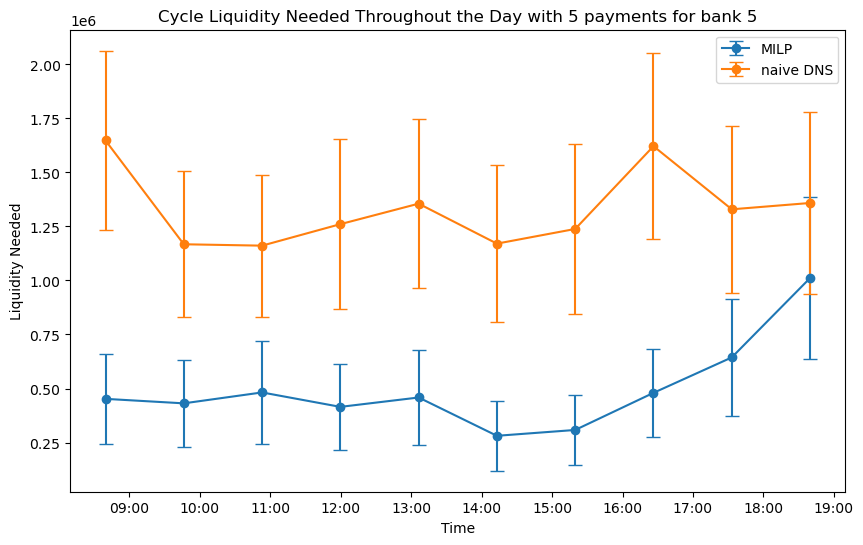

Distribution of cycle liqudity needed (5 payments, bank 6): 
    -0.000000e+00   4.547474e-13   5.684342e-13   9.094947e-13   3.637979e-12  \
0             79              0              0              0              0   
1             61              0              0              0              0   
2             59              0              0              0              0   
3             59              0              0              0              1   
4             58              0              0              0              0   
5             56              0              0              1              0   
6             55              0              0              0              0   
7             56              1              1              0              0   
8             55              1              0              0              0   
9             53              0              0              0              0   

    2.600000e+01   2.278000e+02   3.499000e+02   3.569100

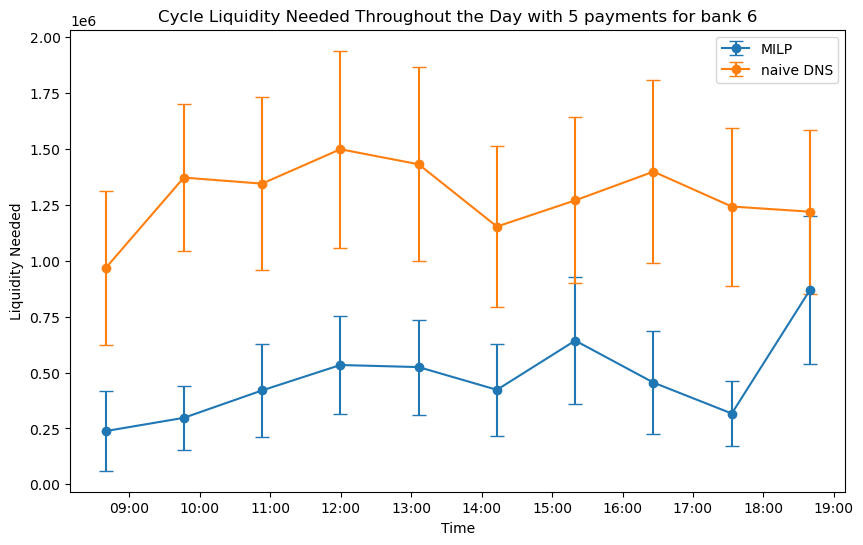

Distribution of cycle liqudity needed (5 payments, bank 7): 
    0.000000e+00  5.684342e-13  2.090000e+00  2.390000e+00  2.798000e+01  \
0            76             0             0             0             0   
1            61             0             0             0             0   
2            62             0             0             0             0   
3            58             0             0             0             0   
4            45             0             1             0             0   
5            42             0             0             0             0   
6            56             0             0             0             0   
7            56             1             0             0             1   
8            52             0             0             0             0   
9            48             0             0             1             0   

   2.551000e+02  2.869300e+02  3.955600e+02  5.216200e+02  6.696300e+02  ...  \
0             0             0   

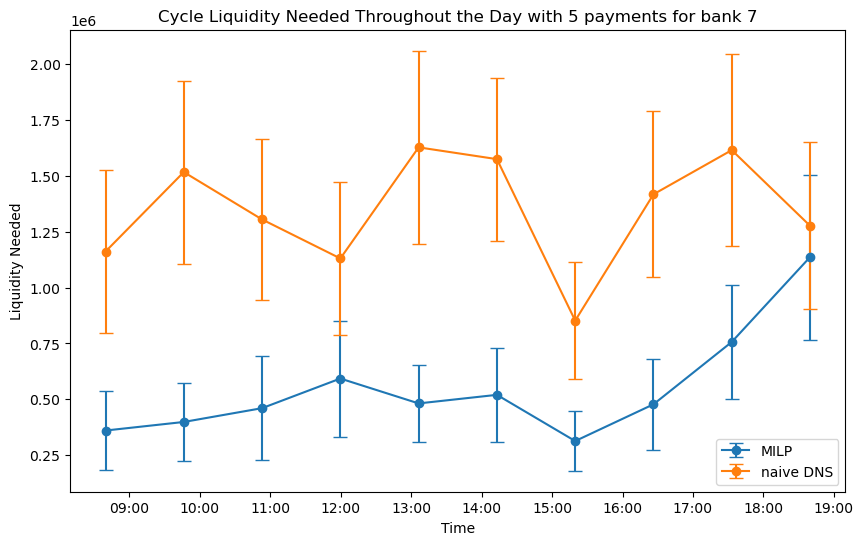

Distribution of cycle liqudity needed (10 payments): 
    0.00         1072.26      1288.51      3280.16      3461.53      \
0            4            0            0            0            0   
1            1            0            0            0            0   
2            1            0            0            0            0   
3            1            0            1            0            0   
4            1            1            0            0            0   
5            0            0            0            0            0   
6            0            0            0            1            1   
7            0            0            0            0            0   
8            2            0            0            0            0   
9            0            0            0            0            0   

   10435.81     12352.75     18542.80     40414.16     44004.35     ...  \
0            0            0            0            0            0  ...   
1            0          

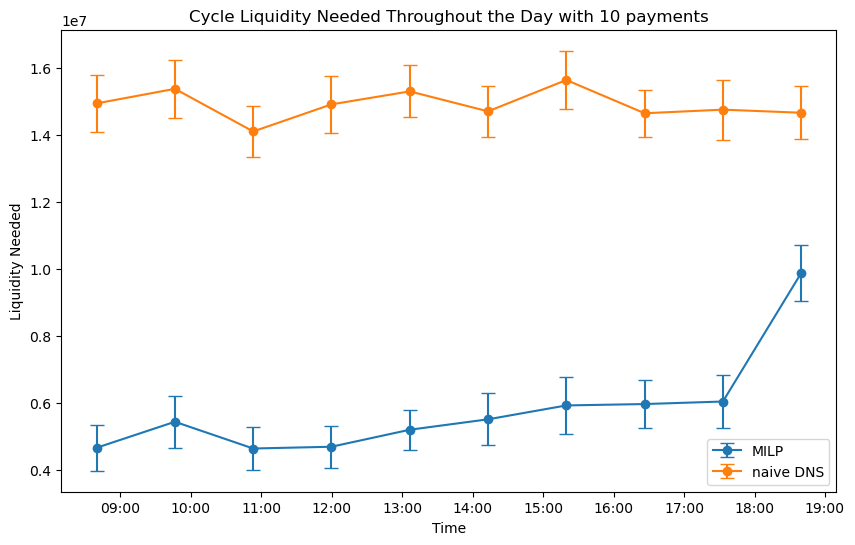

Distribution of cycle liqudity needed (10 payments, bank 0): 
    0.000000e+00  1.421085e-13  6.548362e-11  7.700000e-01  2.480000e+00  \
0            69             0             0             0             0   
1            59             0             0             0             0   
2            54             0             0             0             0   
3            52             0             1             0             0   
4            54             0             0             0             0   
5            49             0             0             0             0   
6            59             1             0             0             0   
7            61             0             0             0             0   
8            53             0             0             0             1   
9            51             0             0             1             0   

   6.510000e+00  7.590000e+00  9.430000e+00  1.208000e+01  1.608000e+01  ...  \
0             0             0  

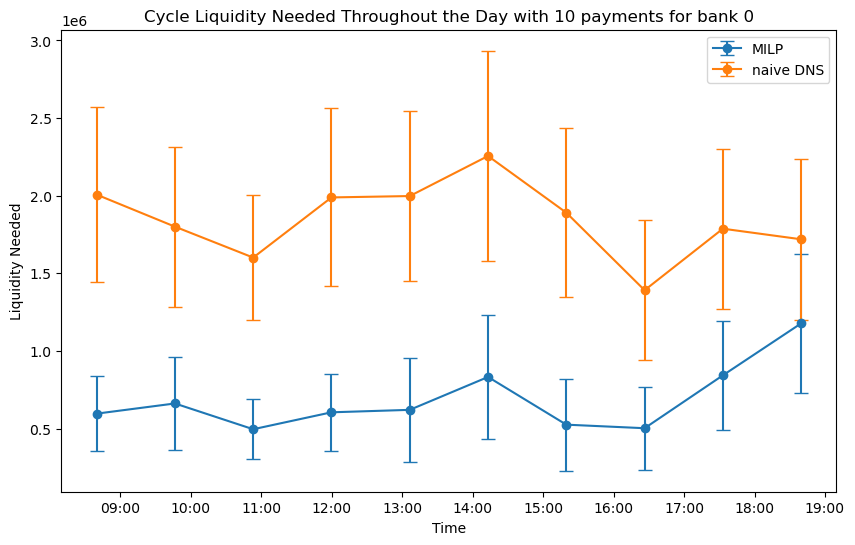

Distribution of cycle liqudity needed (10 payments, bank 1): 
    0.000000e+00  1.705303e-12  7.449330e-11  1.002000e+01  1.064000e+01  \
0            69             0             0             0             0   
1            68             0             0             0             0   
2            65             1             0             0             0   
3            60             0             0             0             0   
4            54             0             0             0             1   
5            50             0             0             0             0   
6            54             0             0             0             0   
7            52             0             0             0             0   
8            56             0             1             1             0   
9            48             0             0             0             0   

   2.245000e+01  4.729000e+01  1.148400e+02  1.360800e+02  1.444600e+02  ...  \
0             0             0  

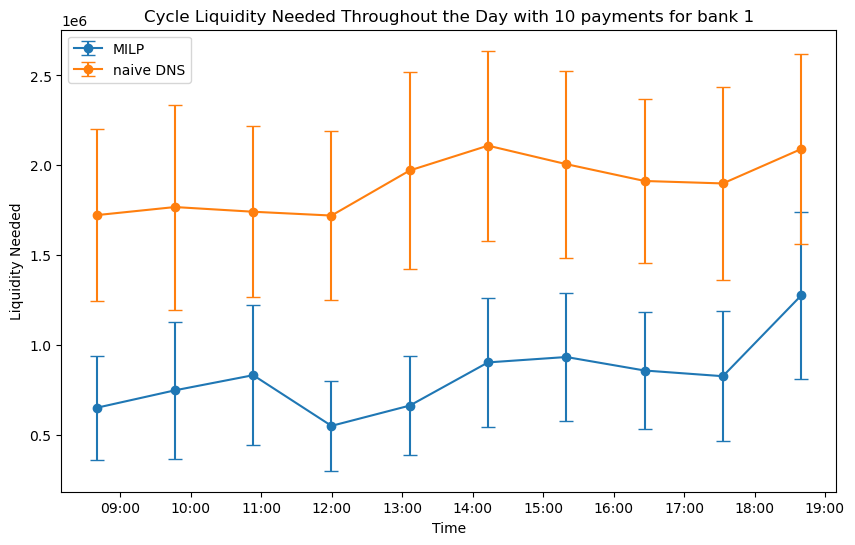

Distribution of cycle liqudity needed (10 payments, bank 2): 
    0.000000e+00  5.456968e-12  4.729372e-11  7.100000e-01  2.240000e+00  \
0            69             0             0             0             0   
1            61             0             0             0             0   
2            60             0             0             0             0   
3            58             0             0             0             0   
4            56             1             0             0             0   
5            53             0             0             0             0   
6            47             0             0             0             0   
7            54             0             0             1             0   
8            57             0             1             0             1   
9            44             0             0             0             0   

   2.980000e+00  4.640000e+00  2.079000e+01  4.560000e+01  7.842000e+01  ...  \
0             0             0  

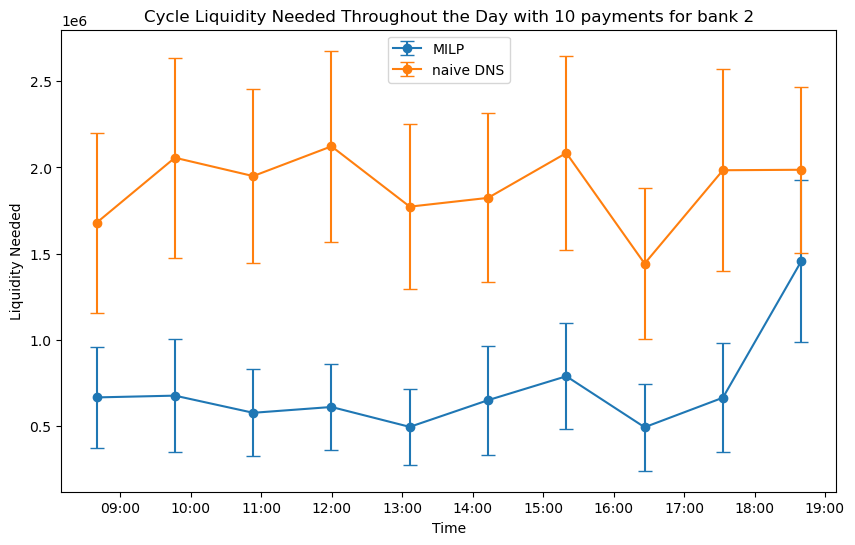

Distribution of cycle liqudity needed (10 payments, bank 3): 
    0.00         2.89         5.38         11.81        38.78        \
0           80            0            0            0            0   
1           66            0            0            0            0   
2           65            0            0            0            0   
3           60            0            0            0            0   
4           60            0            0            0            0   
5           56            0            0            0            1   
6           60            0            0            0            0   
7           59            0            0            1            0   
8           50            1            0            0            0   
9           49            0            1            0            0   

   78.18        106.82       112.52       115.13       163.41       ...  \
0            0            0            0            0            0  ...   
1            0  

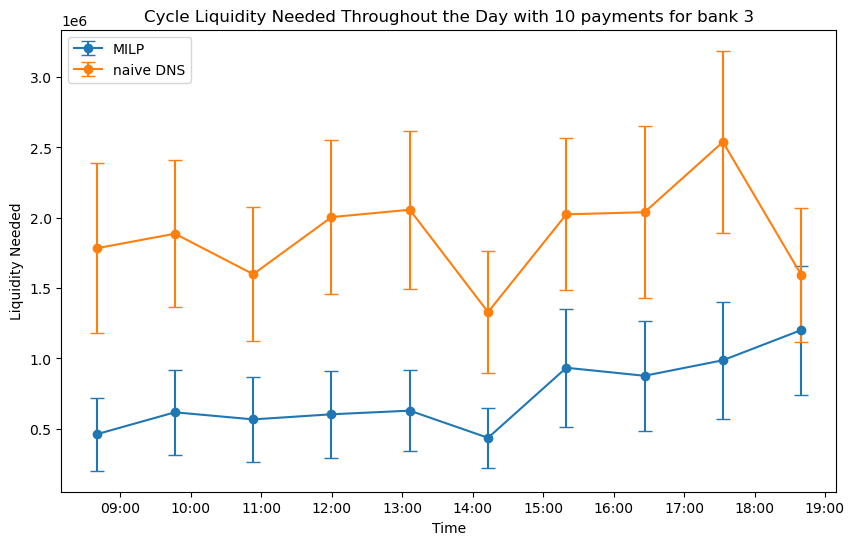

Distribution of cycle liqudity needed (10 payments, bank 4): 
    0.000000e+00  8.881784e-16  2.842171e-14  1.200000e-01  4.200000e-01  \
0            64             0             0             0             0   
1            56             0             0             0             0   
2            54             0             0             0             0   
3            55             0             0             0             0   
4            52             0             1             0             0   
5            51             0             0             0             0   
6            44             0             0             0             0   
7            48             0             0             0             0   
8            52             1             0             0             1   
9            44             0             0             1             0   

   1.620000e+00  1.730000e+00  3.110000e+00  3.590000e+00  4.110000e+00  ...  \
0             0             0  

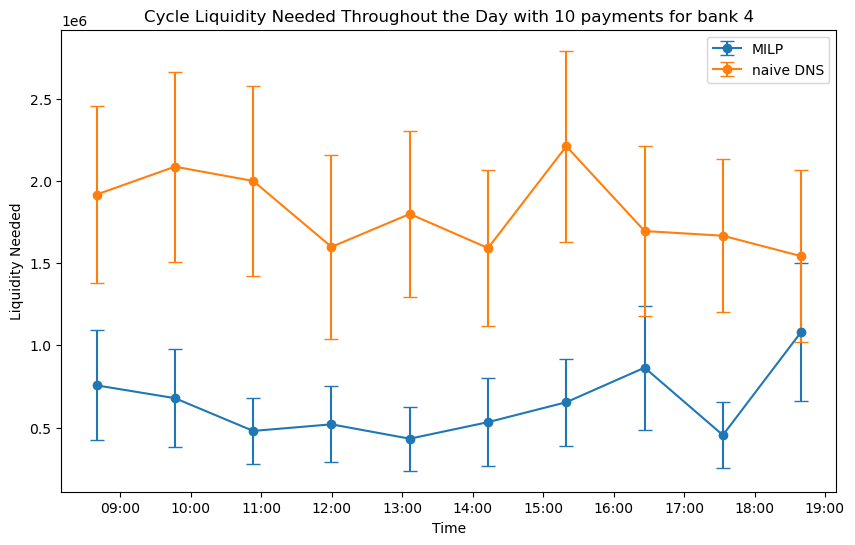

Distribution of cycle liqudity needed (10 payments, bank 5): 
    -0.000000e+00   1.862645e-09   7.700000e+00   1.046000e+01   8.313000e+01  \
0             70              0              0              0              0   
1             68              0              0              0              0   
2             61              0              0              0              0   
3             60              1              0              0              0   
4             60              0              0              0              0   
5             54              0              0              0              0   
6             53              0              0              0              0   
7             46              0              0              0              0   
8             50              0              1              0              0   
9             55              0              0              1              1   

    1.024600e+02   1.039400e+02   2.175500e+02   2.79720

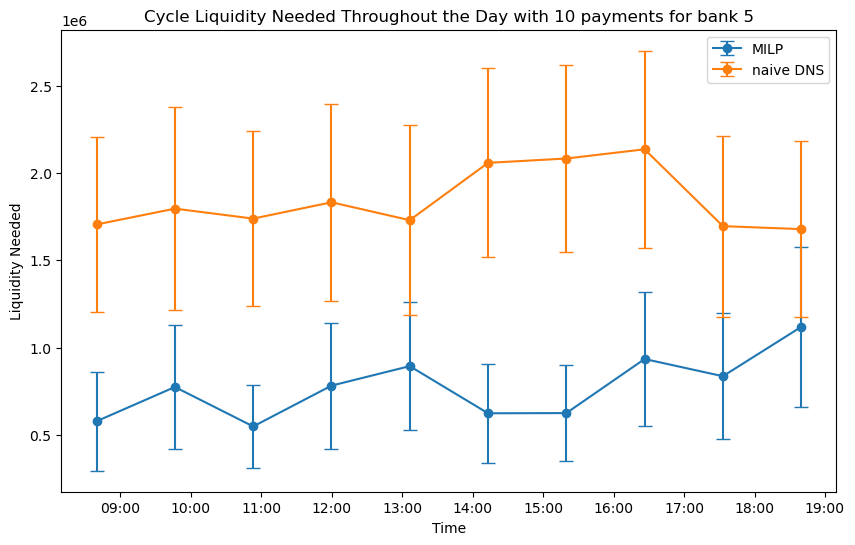

Distribution of cycle liqudity needed (10 payments, bank 6): 
    0.00         0.79         6.90         10.48        16.96        \
0           67            0            0            0            0   
1           64            0            0            0            0   
2           58            0            0            0            0   
3           54            0            0            0            0   
4           52            0            0            0            0   
5           60            0            0            0            0   
6           68            0            0            0            0   
7           56            0            0            0            1   
8           55            1            1            0            0   
9           52            0            0            1            0   

   18.16        36.08        174.66       194.30       252.65       ...  \
0            0            0            0            0            0  ...   
1            0  

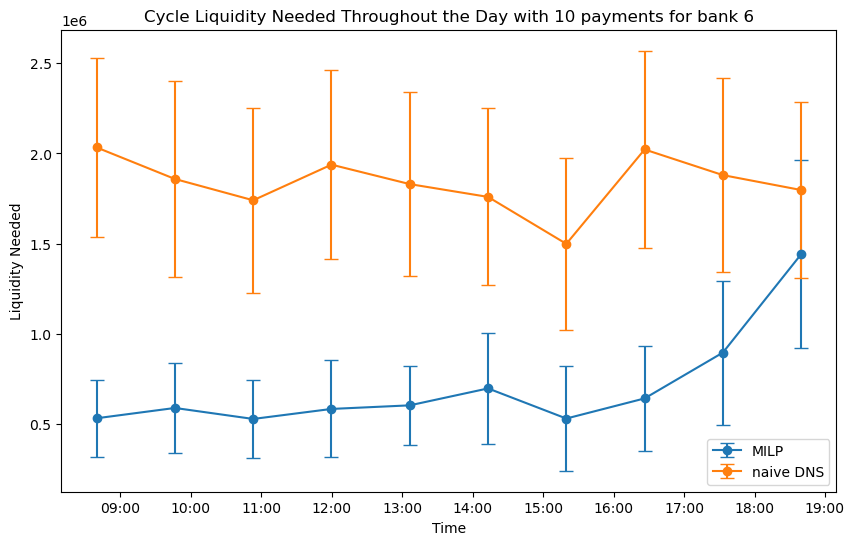

Distribution of cycle liqudity needed (10 payments, bank 7): 
    -0.000000e+00   2.614797e-12   1.020000e+00   2.610000e+00   8.870000e+00  \
0             73              0              0              0              0   
1             64              0              0              0              0   
2             54              0              0              0              0   
3             60              1              0              0              0   
4             51              0              0              0              0   
5             46              0              0              0              0   
6             49              0              0              0              0   
7             47              0              0              0              1   
8             60              0              1              0              0   
9             47              0              0              1              0   

    2.482000e+01   3.763000e+01   4.144000e+01   1.02490

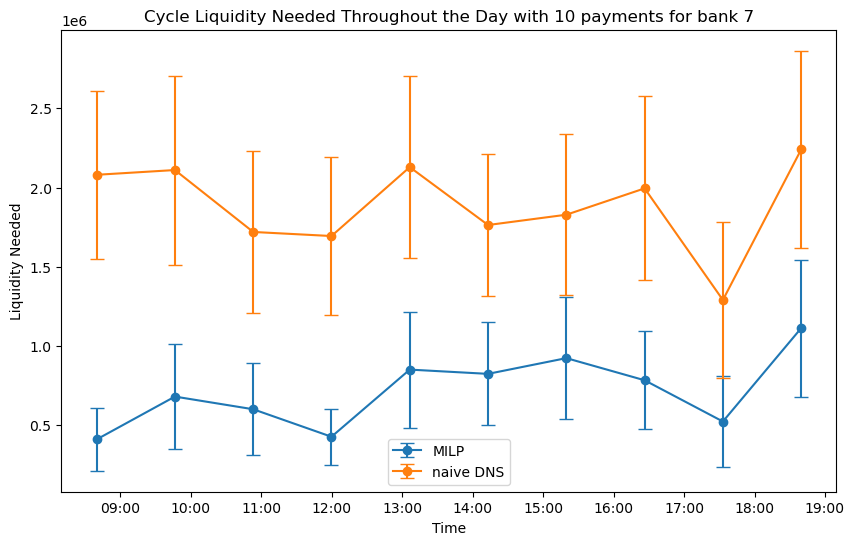

Distribution of cycle liqudity needed (20 payments): 
    0.00         1080.15      1414.58      5107.11      5823.93      \
0            3            0            0            0            0   
1            1            0            0            0            0   
2            0            0            0            0            0   
3            1            0            0            0            0   
4            1            0            0            0            0   
5            0            0            0            1            0   
6            0            1            1            0            0   
7            0            0            0            0            1   
8            0            0            0            0            0   
9            0            0            0            0            0   

   7456.86      34960.74     41554.24     46490.17     49734.77     ...  \
0            0            0            0            1            0  ...   
1            0          

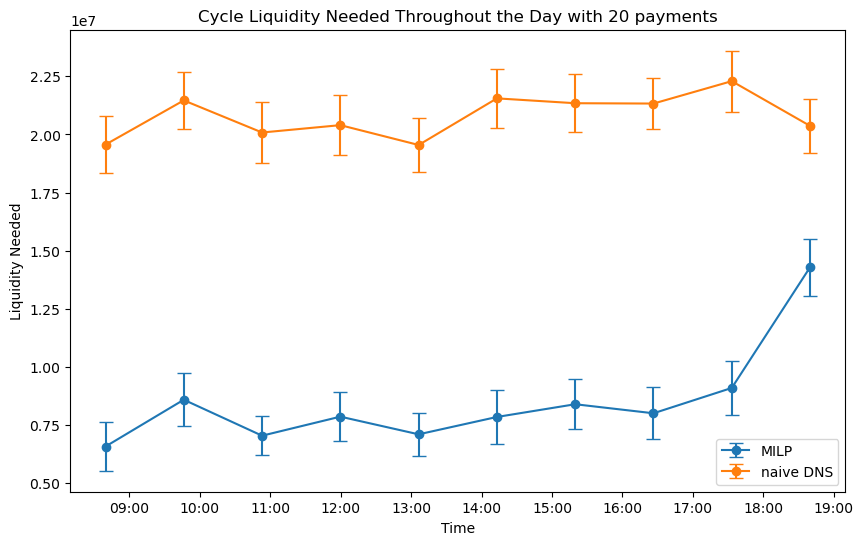

Distribution of cycle liqudity needed (20 payments, bank 0): 
    -0.00          0.02          23.90         26.67         31.00        \
0            78             0             0             0             0   
1            65             0             0             0             0   
2            61             0             0             0             0   
3            63             0             0             0             0   
4            56             0             0             0             0   
5            53             0             0             0             0   
6            59             0             1             0             0   
7            48             0             0             0             0   
8            47             0             0             1             0   
9            50             1             0             0             1   

    39.50         61.59         88.51         108.44        139.01       ...  \
0             0             0  

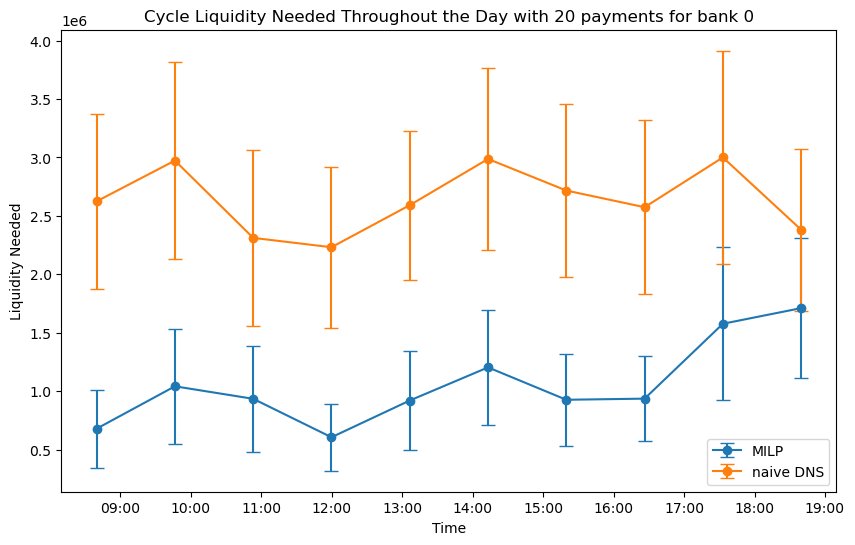

Distribution of cycle liqudity needed (20 payments, bank 1): 
    -0.00          1.06          1.15          2.32          2.33         \
0            75             0             0             0             0   
1            64             0             0             0             0   
2            61             0             0             0             0   
3            51             0             0             0             0   
4            52             0             0             0             0   
5            41             0             0             0             0   
6            47             0             0             0             0   
7            47             0             0             0             0   
8            48             1             1             0             1   
9            52             0             0             1             0   

    2.36          3.58          3.88          7.69          9.63         ...  \
0             0             0  

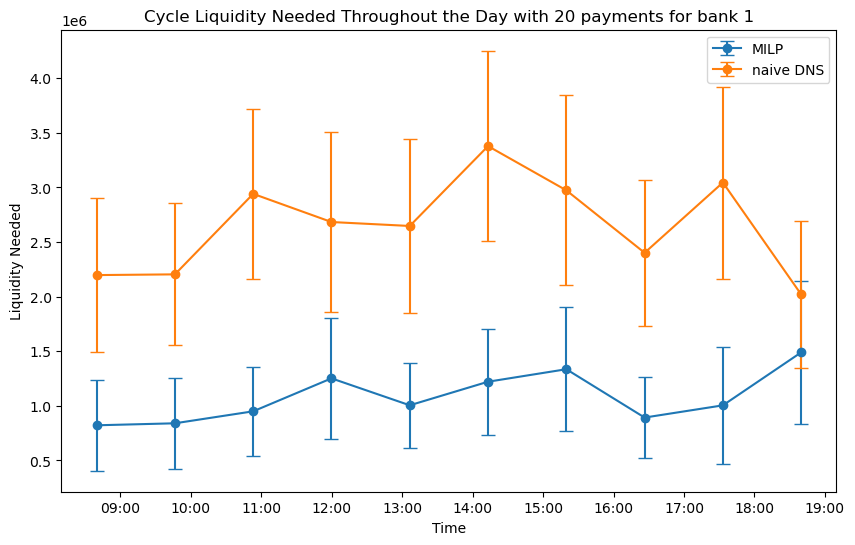

Distribution of cycle liqudity needed (20 payments, bank 2): 
    -0.000000e+00   8.526513e-14   1.790000e+00   1.072000e+01   2.233000e+01  \
0             66              0              0              0              0   
1             60              0              0              0              0   
2             53              0              0              0              0   
3             55              1              0              0              0   
4             66              0              0              0              0   
5             58              0              1              0              0   
6             57              0              0              0              0   
7             59              0              0              0              1   
8             54              0              0              1              0   
9             48              0              0              0              0   

    2.958000e+01   5.267000e+01   6.417000e+01   6.71400

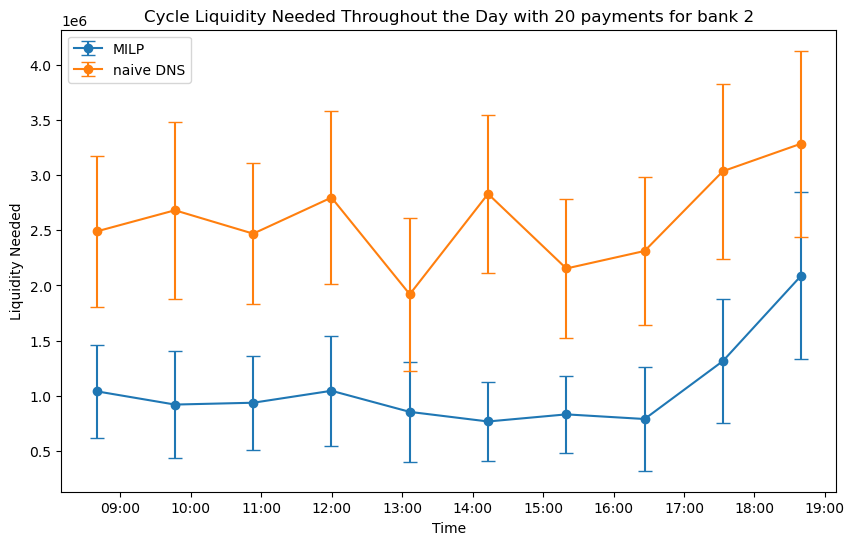

Distribution of cycle liqudity needed (20 payments, bank 3): 
    0.000000e+00  1.065814e-14  3.800000e-01  4.700000e-01  1.840000e+00  \
0            68             0             0             0             0   
1            58             0             0             0             0   
2            47             0             0             0             0   
3            59             0             0             0             0   
4            50             1             0             0             0   
5            59             0             0             0             0   
6            45             0             0             0             0   
7            48             0             1             0             0   
8            49             0             0             1             1   
9            54             0             0             0             0   

   2.110000e+00  2.220000e+00  4.020000e+00  4.220000e+00  6.810000e+00  ...  \
0             0             0  

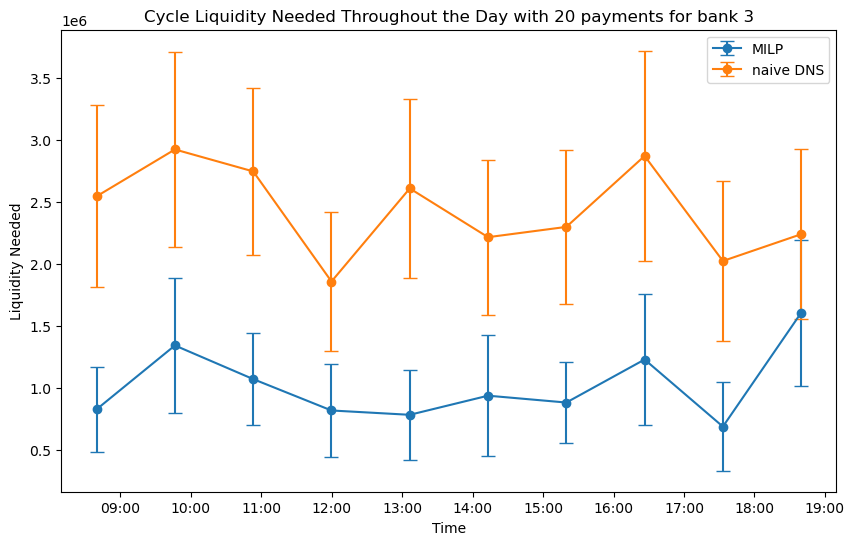

Distribution of cycle liqudity needed (20 payments, bank 4): 
    -0.00          0.35          2.73          3.32          6.41         \
0            63             0             0             0             0   
1            63             0             0             0             0   
2            55             0             0             0             0   
3            52             0             0             0             0   
4            60             0             0             0             0   
5            56             0             0             0             0   
6            59             0             0             0             0   
7            58             0             0             0             1   
8            50             0             1             1             0   
9            54             1             0             0             0   

    19.89         26.22         39.31         56.72         59.06        ...  \
0             0             0  

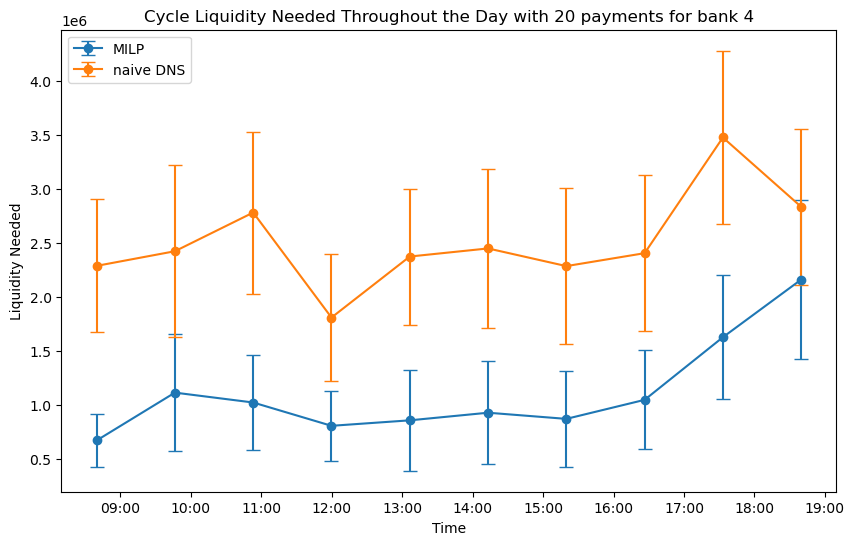

Distribution of cycle liqudity needed (20 payments, bank 5): 
    -0.00          0.45          0.60          0.63          2.43         \
0            76             0             0             0             0   
1            68             0             0             0             0   
2            67             0             0             0             0   
3            66             0             0             0             0   
4            61             0             0             0             0   
5            64             0             0             0             0   
6            67             0             0             0             0   
7            62             0             1             0             0   
8            63             1             0             0             0   
9            53             0             0             1             1   

    3.47          15.34         54.51         56.53         199.64       ...  \
0             0             0  

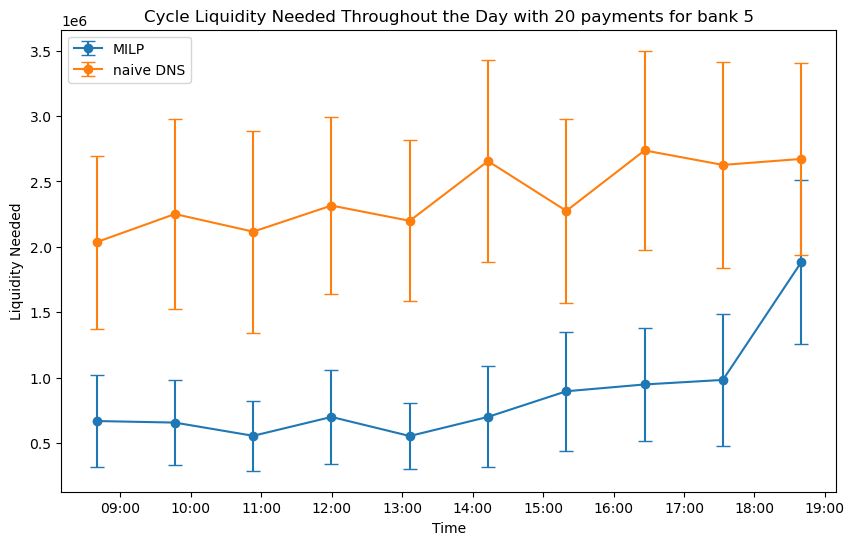

Distribution of cycle liqudity needed (20 payments, bank 6): 
    -0.00          0.01          0.03          0.07          0.21         \
0            66             0             0             0             0   
1            53             0             0             0             0   
2            56             0             0             0             0   
3            44             0             0             0             0   
4            43             0             0             0             0   
5            48             0             0             0             0   
6            41             0             1             0             0   
7            49             1             0             0             0   
8            42             0             0             0             1   
9            45             0             0             1             0   

    0.22          0.43          0.65          0.92          1.58         ...  \
0             0             0  

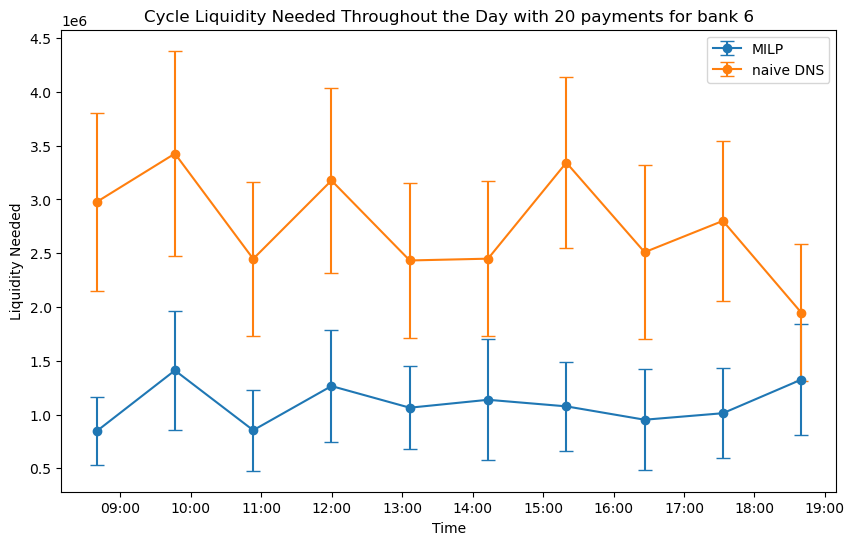

Distribution of cycle liqudity needed (20 payments, bank 7): 
    0.000000e+00  4.638423e-11  1.670000e+00  1.165000e+01  1.294000e+01  \
0            67             0             0             0             0   
1            60             0             0             0             0   
2            61             0             0             0             0   
3            52             1             0             0             0   
4            52             0             0             0             0   
5            49             0             0             0             0   
6            46             0             0             0             1   
7            49             0             0             0             0   
8            50             0             0             0             0   
9            47             0             1             1             0   

   1.916000e+01  2.680000e+01  5.526000e+01  7.294000e+01  8.478000e+01  ...  \
0             0             0  

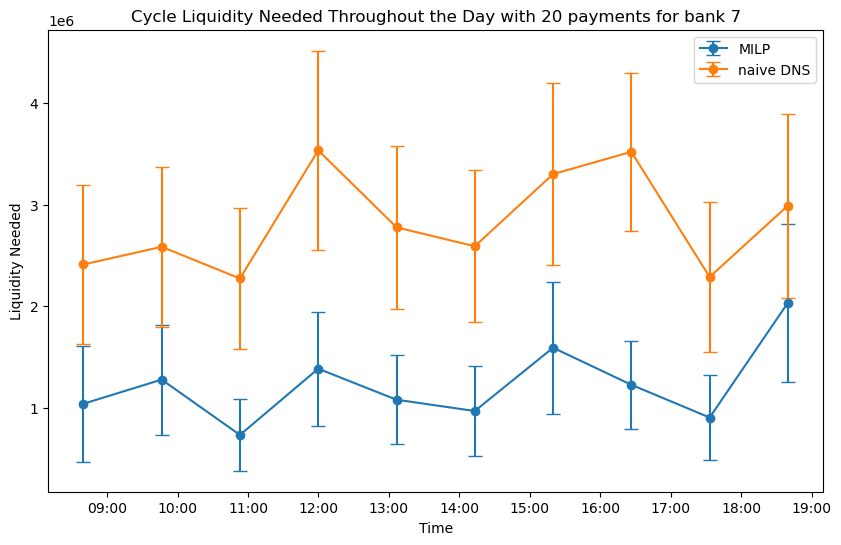

Distribution of cycle liqudity needed (50 payments): 
    0.00         316.42       1019.41      1604.33      3435.49      \
0            4            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            1            0            0            0   
5            0            0            1            0            1   
6            0            0            0            1            0   
7            0            0            0            0            0   
8            0            0            0            0            0   
9            0            0            0            0            0   

   4118.21      5038.59      5390.12      11601.41     11787.03     ...  \
0            0            0            0            0            0  ...   
1            0          

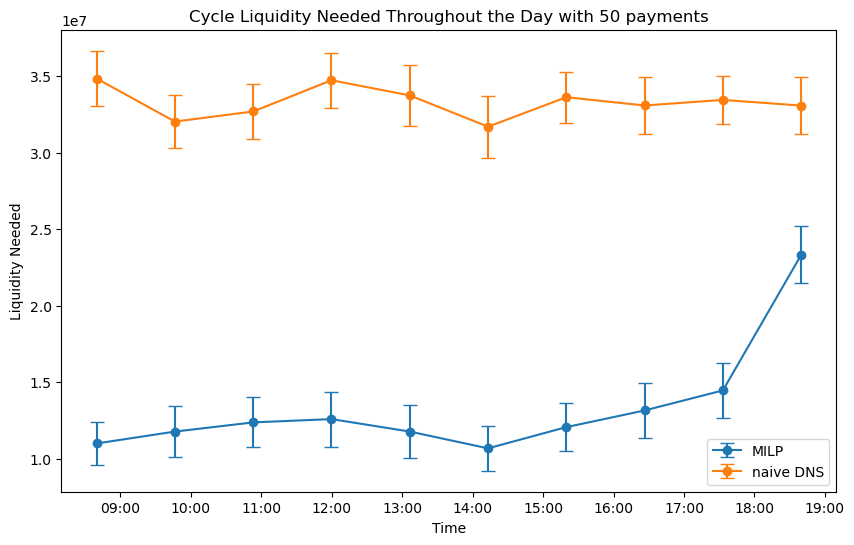

Distribution of cycle liqudity needed (50 payments, bank 0): 
    -0.00          0.09          0.40          0.47          0.76         \
0            80             0             0             0             0   
1            70             0             0             0             0   
2            59             0             0             0             0   
3            48             0             0             0             0   
4            47             1             0             0             0   
5            57             0             0             0             0   
6            56             0             0             0             0   
7            50             0             0             1             1   
8            53             0             0             0             0   
9            57             0             1             0             0   

    1.73          2.35          5.66          6.02          6.34         ...  \
0             0             0  

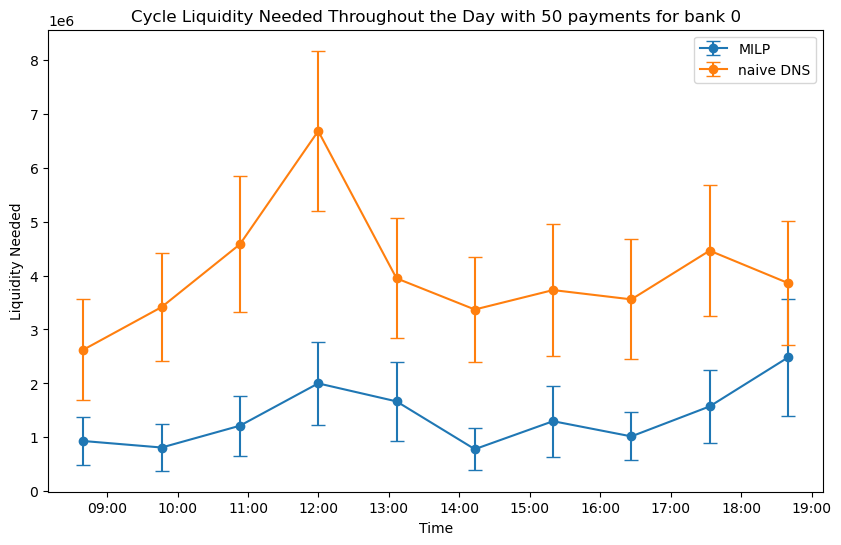

Distribution of cycle liqudity needed (50 payments, bank 1): 
    0.000000e+00  7.448762e-10  9.700000e-01  1.220000e+00  3.330000e+00  \
0            70             0             0             0             0   
1            62             0             0             0             0   
2            56             0             0             0             0   
3            62             0             0             0             0   
4            57             0             0             0             0   
5            60             1             0             1             0   
6            56             0             0             0             0   
7            59             0             0             0             0   
8            53             0             1             0             0   
9            52             0             0             0             1   

   4.520000e+00  1.278000e+01  2.895000e+01  2.904000e+01  3.931000e+01  ...  \
0             0             0  

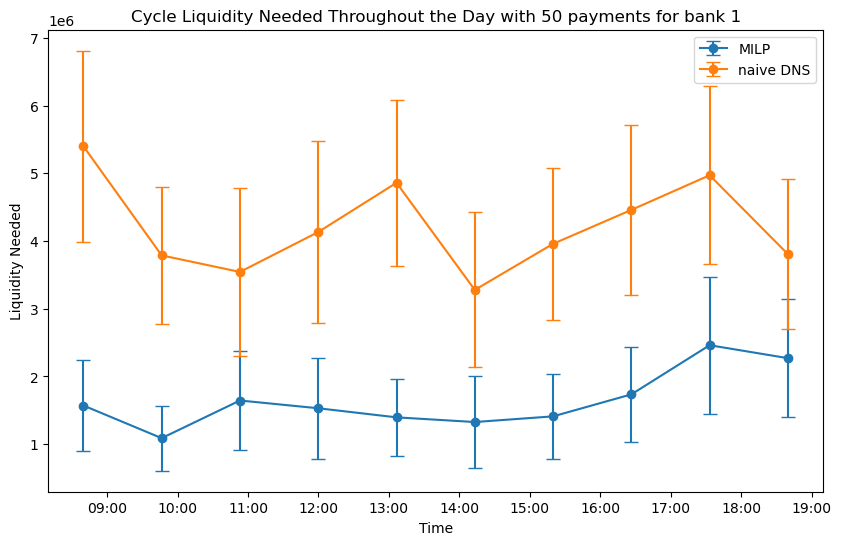

Distribution of cycle liqudity needed (50 payments, bank 2): 
    -0.00          0.02          0.49          0.74          0.80         \
0            72             0             0             0             0   
1            67             0             0             0             0   
2            60             0             0             0             0   
3            61             0             0             0             0   
4            54             0             0             0             0   
5            53             0             0             0             0   
6            54             1             0             0             1   
7            52             0             1             0             0   
8            48             0             0             1             0   
9            53             0             0             0             0   

    1.60          4.63          7.96          10.29         13.02        ...  \
0             0             0  

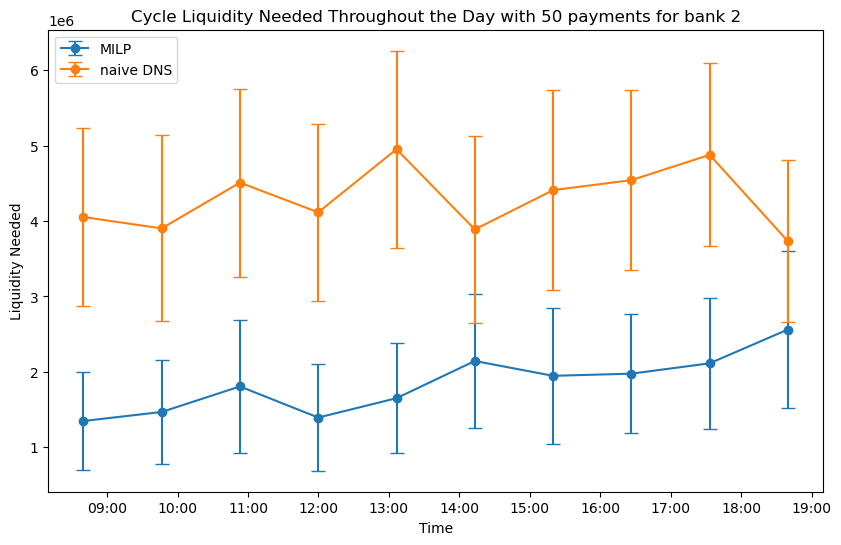

Distribution of cycle liqudity needed (50 payments, bank 3): 
    -0.00          0.85          1.81          4.60          8.71         \
0            66             0             0             0             0   
1            62             0             0             0             0   
2            57             0             0             0             0   
3            57             0             0             0             0   
4            49             0             0             0             0   
5            53             0             0             0             0   
6            51             0             1             0             0   
7            58             1             0             0             0   
8            49             0             0             1             0   
9            47             0             0             0             1   

    10.00         11.25         14.90         21.78         22.87        ...  \
0             0             0  

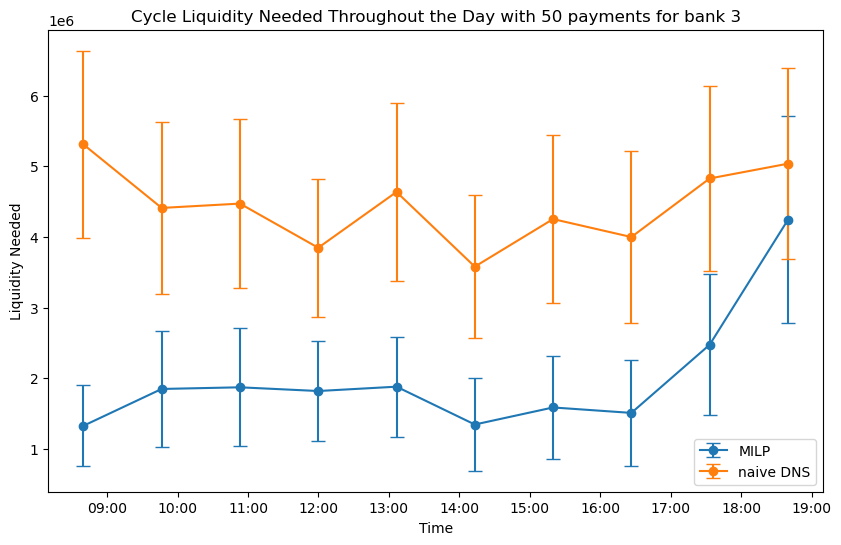

Distribution of cycle liqudity needed (50 payments, bank 4): 
    0.00         0.12         0.66         1.84         2.84         \
0           62            0            0            0            0   
1           57            0            0            0            0   
2           52            0            0            0            0   
3           61            1            0            0            0   
4           56            0            1            0            0   
5           48            0            0            0            0   
6           51            0            0            0            0   
7           51            0            0            1            0   
8           50            0            0            0            1   
9           41            0            0            0            0   

   3.66         4.71         5.17         6.99         9.53         ...  \
0            0            0            0            0            0  ...   
1            0  

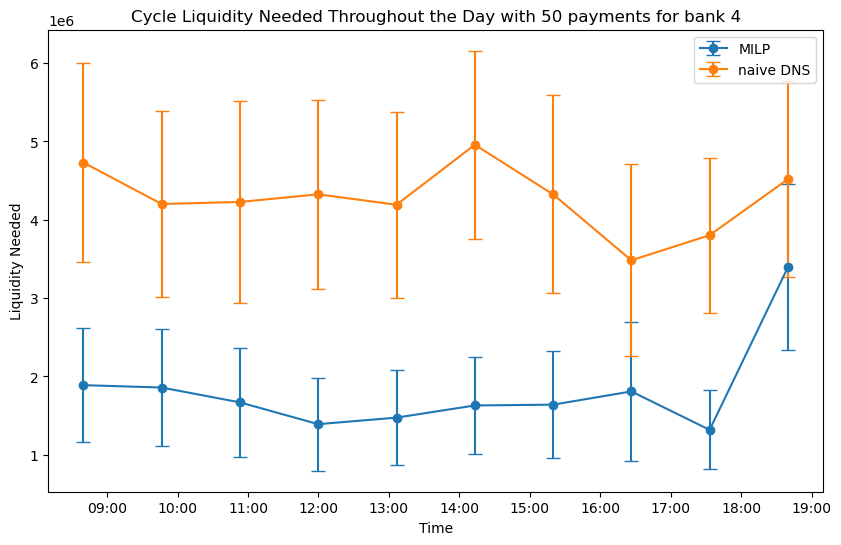

Distribution of cycle liqudity needed (50 payments, bank 5): 
    -0.00          2.09          2.61          4.98          9.80         \
0            75             0             0             0             0   
1            60             0             0             0             0   
2            56             0             0             0             0   
3            62             0             0             0             0   
4            57             0             0             0             0   
5            60             0             0             1             0   
6            57             0             0             0             0   
7            52             0             0             0             1   
8            58             0             1             0             0   
9            53             1             0             0             0   

    12.08         14.43         15.20         17.45         22.38        ...  \
0             0             0  

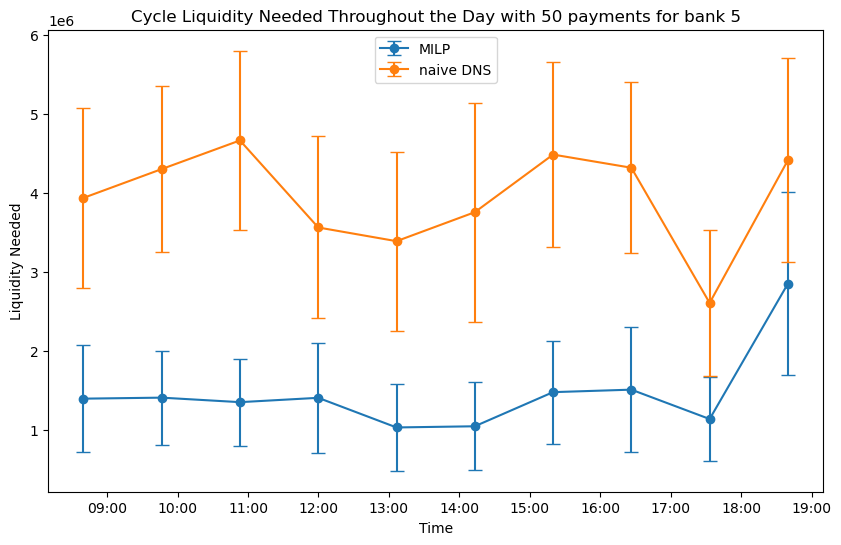

Distribution of cycle liqudity needed (50 payments, bank 6): 
    -0.00          0.45          0.67          2.42          4.28         \
0            69             0             0             0             0   
1            63             0             0             0             0   
2            62             0             0             0             0   
3            56             0             0             0             0   
4            60             0             0             0             0   
5            57             0             0             0             0   
6            53             0             0             1             0   
7            49             0             0             0             0   
8            53             1             1             0             0   
9            50             0             0             0             1   

    6.59          8.85          9.68          9.72          16.22        ...  \
0             0             0  

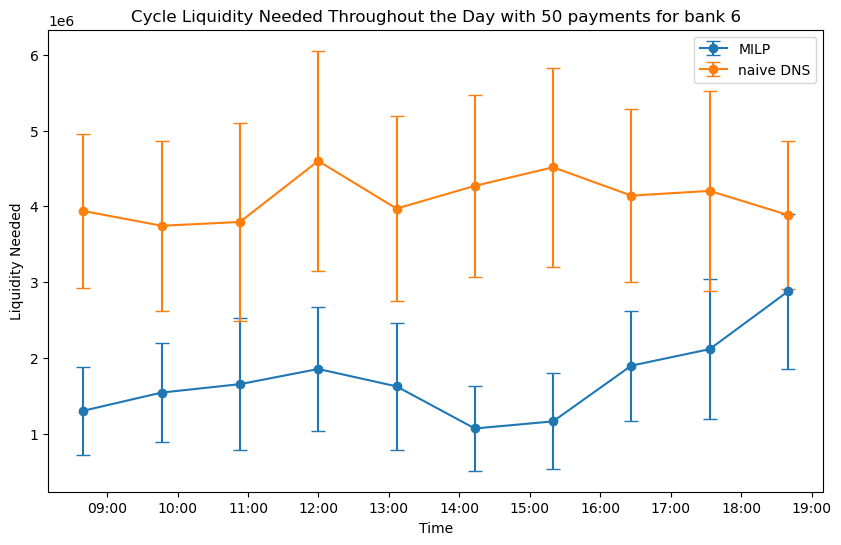

Distribution of cycle liqudity needed (50 payments, bank 7): 
    -0.00          0.04          1.54          2.46          4.92         \
0            68             0             0             0             0   
1            63             0             0             0             0   
2            55             0             0             0             0   
3            60             0             0             0             0   
4            53             1             0             0             0   
5            56             0             0             0             0   
6            53             0             0             0             1   
7            51             0             0             1             0   
8            53             0             0             0             0   
9            50             0             1             0             0   

    4.94          7.87          19.95         24.00         35.17        ...  \
0             0             0  

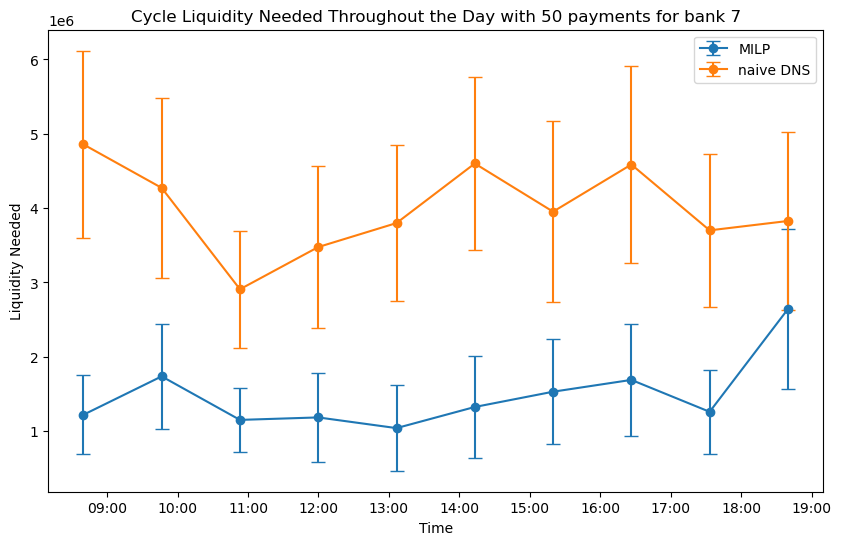

Distribution of cycle liqudity needed (100 payments): 
    0.00         98.56        917.62       920.21       3270.18      \
0            3            0            0            0            0   
1            1            0            0            0            0   
2            0            1            0            0            0   
3            0            0            0            0            1   
4            0            0            0            1            0   
5            0            0            1            0            0   
6            0            0            0            0            0   
7            0            0            0            0            0   
8            0            0            0            0            0   
9            0            0            0            0            0   

   11874.97     17067.36     17450.92     22172.98     29636.52     ...  \
0            0            0            0            0            0  ...   
1            0         

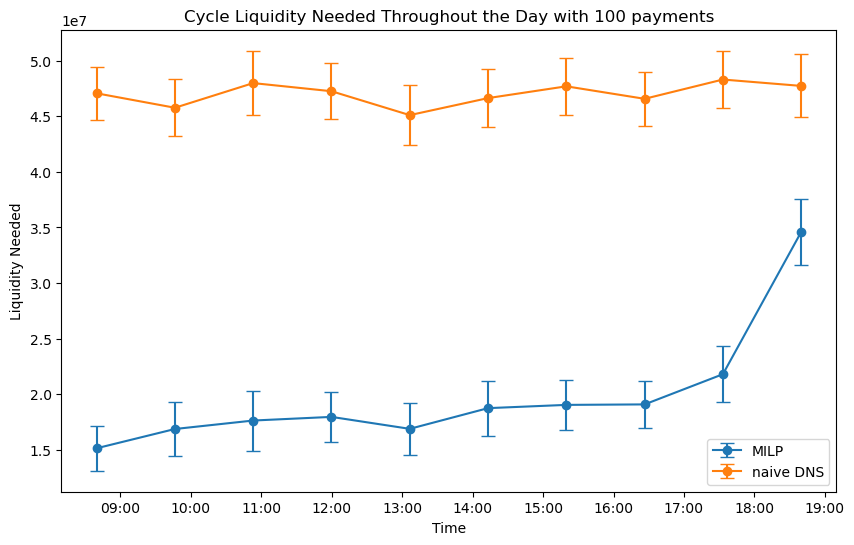

Distribution of cycle liqudity needed (100 payments, bank 0): 
    0.000000e+00  8.326673e-17  8.881784e-16  1.000000e-01  1.100000e-01  \
0            71             0             0             0             0   
1            67             0             0             0             0   
2            56             0             0             0             0   
3            56             0             0             0             0   
4            51             0             0             0             0   
5            52             0             0             0             0   
6            51             0             0             0             0   
7            48             0             1             0             0   
8            51             1             0             0             1   
9            51             0             0             1             0   

   1.200000e-01  2.400000e-01  3.200000e-01  3.600000e-01  5.900000e-01  ...  \
0             0             0 

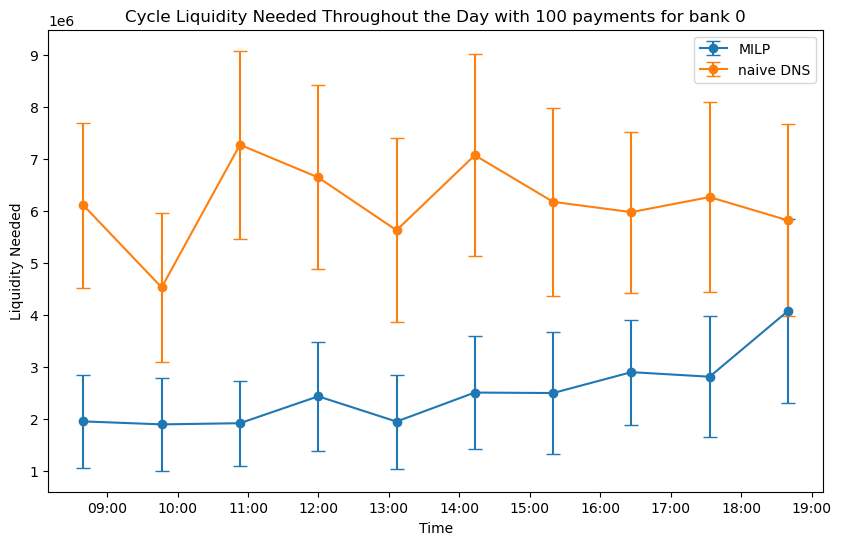

Distribution of cycle liqudity needed (100 payments, bank 1): 
    -0.000000e+00   4.365575e-11   3.500000e-01   1.180000e+00   1.930000e+00  \
0             70              0              0              0              0   
1             69              0              0              0              0   
2             65              0              0              0              0   
3             58              1              0              0              0   
4             56              0              0              0              1   
5             65              0              0              0              0   
6             59              0              0              1              0   
7             59              0              0              0              0   
8             59              0              1              0              0   
9             58              0              0              0              0   

    2.050000e+00   2.310000e+00   2.390000e+00   2.6500

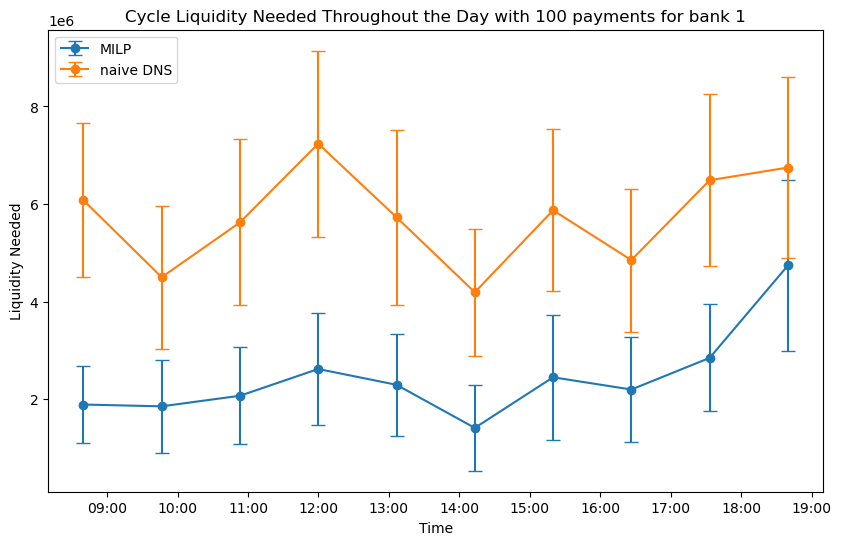

Distribution of cycle liqudity needed (100 payments, bank 2): 
    0.000000e+00  2.619345e-10  8.000000e-02  2.850000e+00  3.330000e+00  \
0            66             0             0             0             0   
1            58             0             0             0             0   
2            65             0             0             0             0   
3            60             0             0             0             1   
4            61             0             0             0             0   
5            59             0             0             0             0   
6            57             1             0             0             0   
7            55             0             0             1             0   
8            52             0             0             0             0   
9            55             0             1             0             0   

   4.130000e+00  4.410000e+00  1.872000e+01  2.134000e+01  2.183000e+01  ...  \
0             0             0 

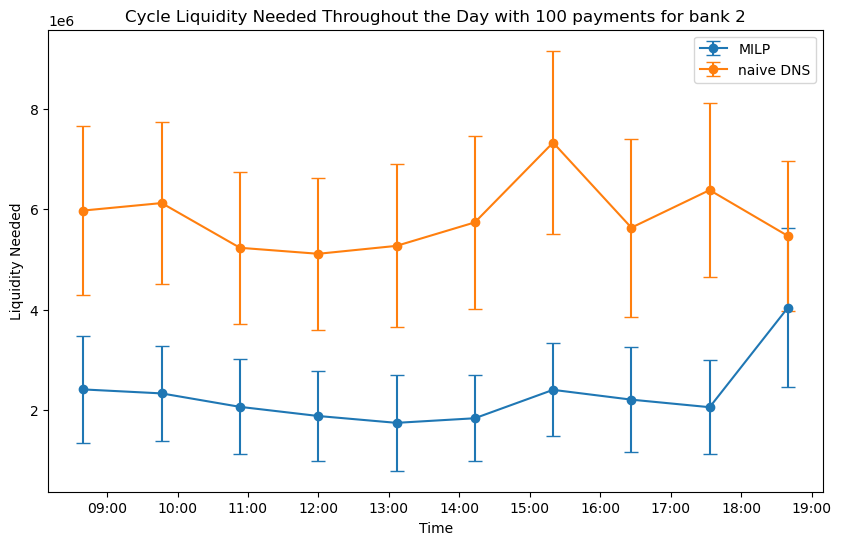

Distribution of cycle liqudity needed (100 payments, bank 3): 
    -0.000000e+00   9.103829e-15   6.000000e-02   4.700000e-01   8.200000e-01  \
0             81              0              0              0              0   
1             66              0              0              0              0   
2             60              0              0              0              0   
3             60              0              0              0              0   
4             59              1              0              0              0   
5             55              0              0              0              0   
6             51              0              0              0              0   
7             52              0              0              1              0   
8             49              0              0              0              0   
9             59              0              1              0              1   

    1.260000e+00   1.980000e+00   2.720000e+00   3.1800

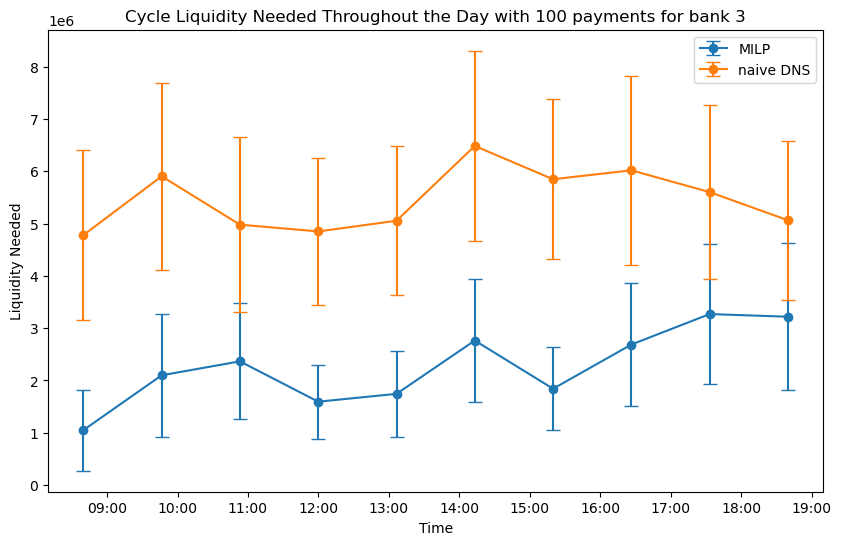

Distribution of cycle liqudity needed (100 payments, bank 4): 
    -0.000000e+00   2.220446e-16   9.200000e-01   1.190000e+00   1.800000e+00  \
0             74              0              0              0              0   
1             64              0              0              0              0   
2             62              0              0              0              0   
3             58              0              0              0              0   
4             52              0              0              0              1   
5             59              0              0              0              0   
6             55              1              0              0              0   
7             51              0              0              1              0   
8             45              0              1              0              0   
9             46              0              0              0              0   

    3.980000e+00   4.340000e+00   1.026000e+01   1.0550

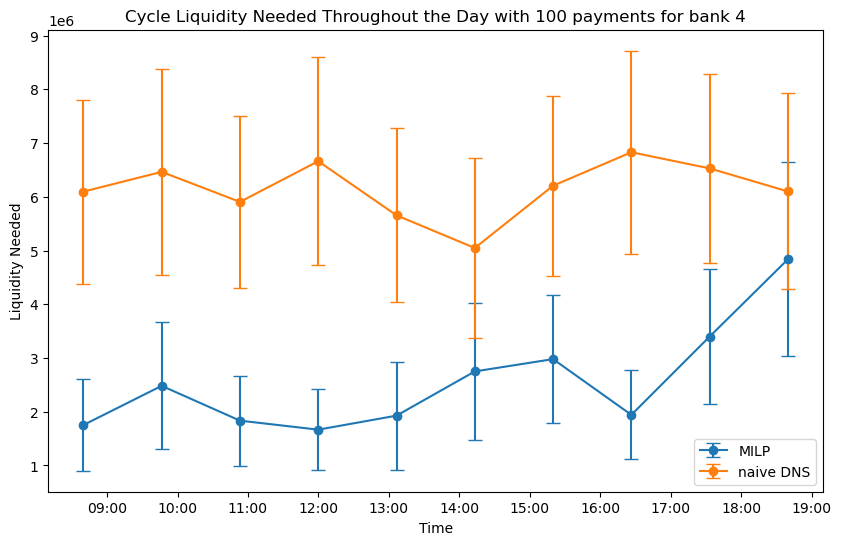

Distribution of cycle liqudity needed (100 payments, bank 5): 
    -0.00          0.01          0.15          0.35          1.51         \
0            68             0             0             0             0   
1            57             0             0             0             0   
2            56             0             0             0             0   
3            52             0             0             0             0   
4            54             0             0             0             0   
5            47             1             0             0             0   
6            53             0             0             0             0   
7            49             0             1             0             0   
8            58             0             0             0             0   
9            46             0             0             1             1   

    1.76          1.80          3.30          3.81          5.01         ...  \
0             0             0 

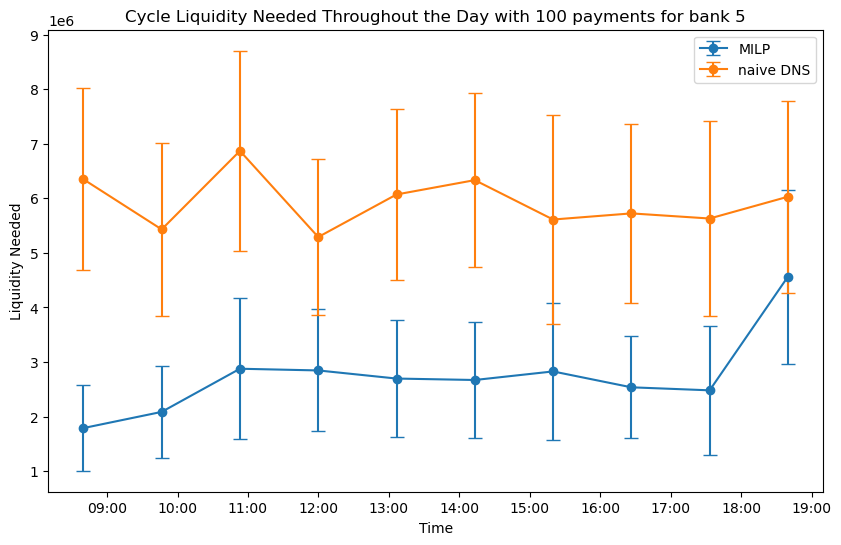

Distribution of cycle liqudity needed (100 payments, bank 6): 
    0.000000e+00  1.110223e-16  2.842171e-14  1.000000e-01  2.000000e-01  \
0            69             0             0             0             0   
1            60             0             0             0             0   
2            57             0             0             0             0   
3            53             0             0             0             0   
4            52             0             1             0             0   
5            50             0             0             0             0   
6            57             0             0             0             0   
7            53             0             0             0             0   
8            54             1             0             1             0   
9            45             0             0             0             1   

   6.400000e-01  1.680000e+00  1.920000e+00  2.240000e+00  2.240000e+00  ...  \
0             0             0 

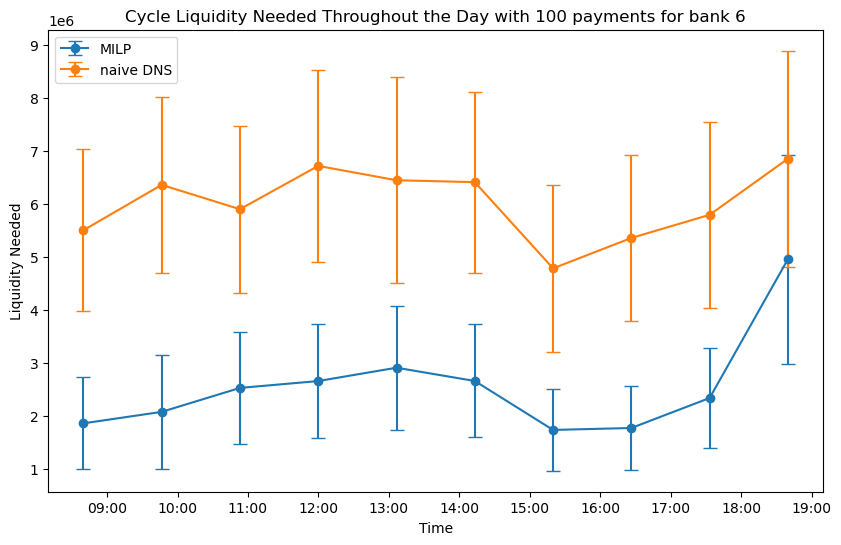

Distribution of cycle liqudity needed (100 payments, bank 7): 
    0.00         0.01         0.13         0.13         0.21         \
0           68            0            0            0            0   
1           55            0            0            0            0   
2           58            0            0            0            0   
3           59            0            0            0            0   
4           56            0            0            0            0   
5           57            0            1            0            0   
6           49            0            0            0            0   
7           50            0            0            0            1   
8           47            1            0            1            0   
9           51            0            0            0            0   

   1.17         1.19         1.23         1.28         1.36         ...  \
0            0            0            0            0            0  ...   
1            0 

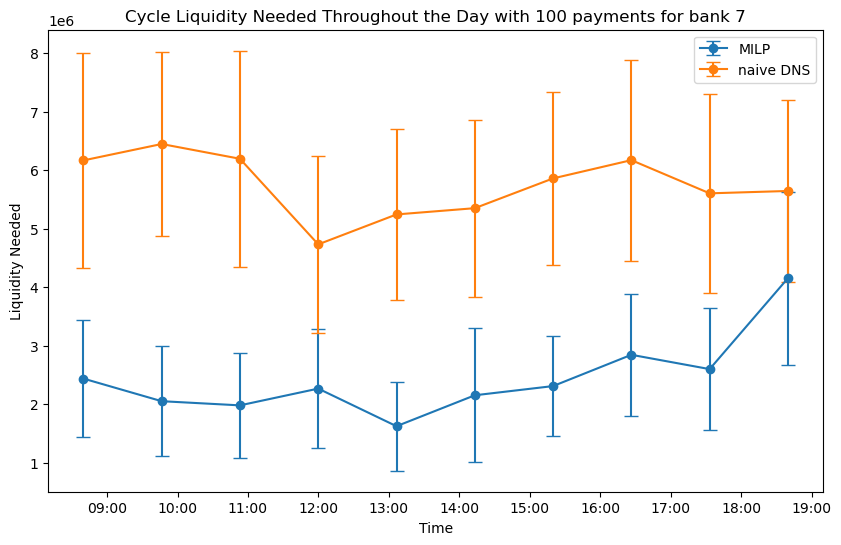

Distribution of cycle liqudity needed (300 payments): 
    0.000000e+00  5.162000e+01  5.190900e+02  6.669760e+03  7.003614e+04  \
0             2             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             1             1             0             1   
5             1             0             0             1             0   
6             0             0             0             0             0   
7             0             0             0             0             0   
8             0             0             0             0             0   
9             0             0             0             0             0   

   8.973203e+04  1.013215e+05  1.877611e+05  2.743827e+05  3.603235e+05  ...  \
0             0             0         

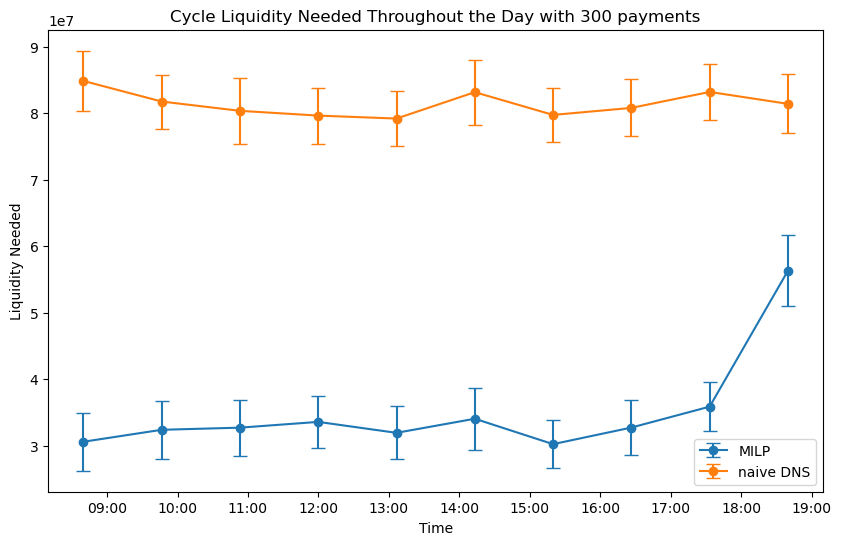

Distribution of cycle liqudity needed (300 payments, bank 0): 
    -0.000000e+00   4.996004e-16   3.108624e-15   3.492318e-12   3.000000e-02  \
0             65              0              0              0              0   
1             59              0              0              0              0   
2             47              0              0              1              0   
3             52              0              0              0              0   
4             46              0              1              0              0   
5             54              0              0              0              0   
6             48              1              0              0              0   
7             52              0              0              0              0   
8             53              0              0              0              1   
9             51              0              0              0              0   

    1.300000e-01   1.300000e-01   7.000000e-01   8.8000

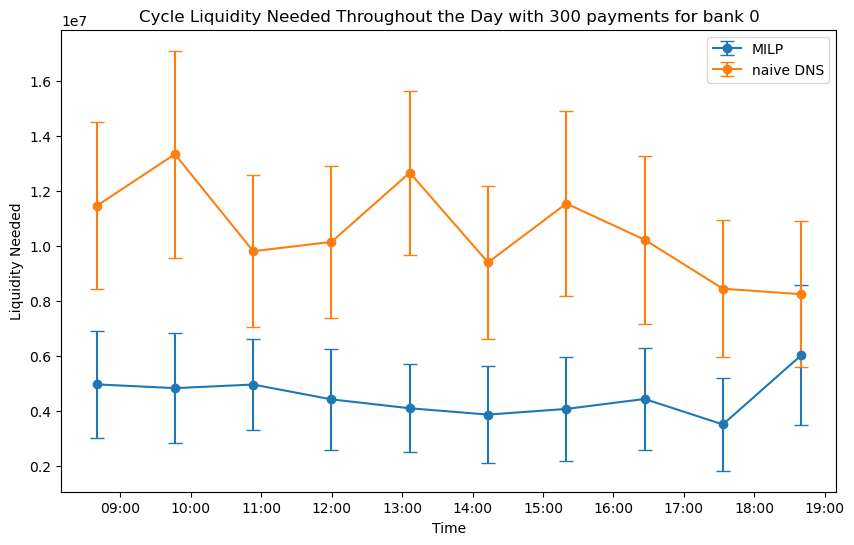

Distribution of cycle liqudity needed (300 payments, bank 1): 
    0.00         0.33         1.01         1.35         2.51         \
0           70            0            0            0            0   
1           70            0            0            0            0   
2           60            0            0            0            0   
3           58            0            0            0            0   
4           49            0            1            0            0   
5           61            0            0            0            0   
6           55            0            0            0            1   
7           61            0            0            1            0   
8           46            1            0            0            0   
9           49            0            0            0            0   

   3.02         3.74         8.11         11.85        13.91        ...  \
0            0            0            0            0            0  ...   
1            0 

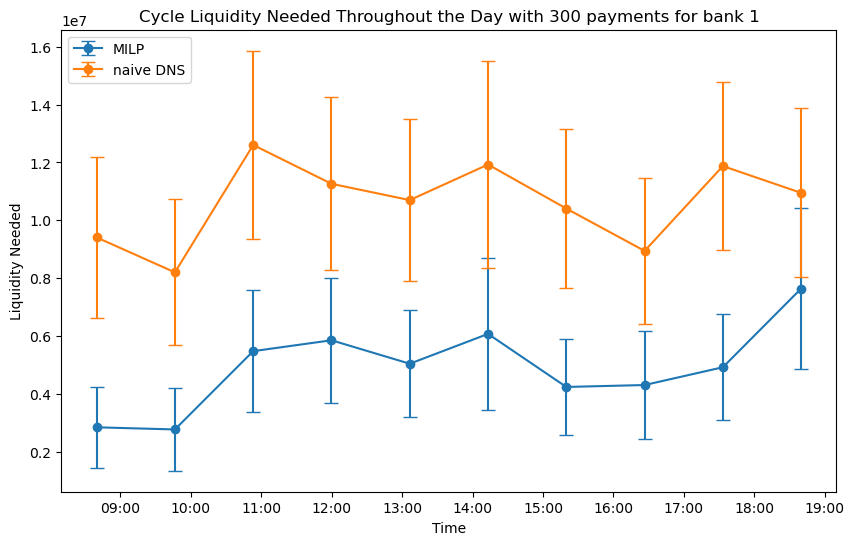

Distribution of cycle liqudity needed (300 payments, bank 2): 
    -0.000000e+00   5.551115e-17   9.059420e-14   1.000000e-01   2.400000e-01  \
0             66              0              0              0              0   
1             61              0              0              0              0   
2             56              0              0              0              0   
3             58              0              0              0              0   
4             55              1              0              0              0   
5             53              0              1              1              0   
6             53              0              0              0              0   
7             49              0              0              0              1   
8             50              0              0              0              0   
9             49              0              0              0              0   

    2.500000e-01   3.600000e-01   8.000000e-01   8.8000

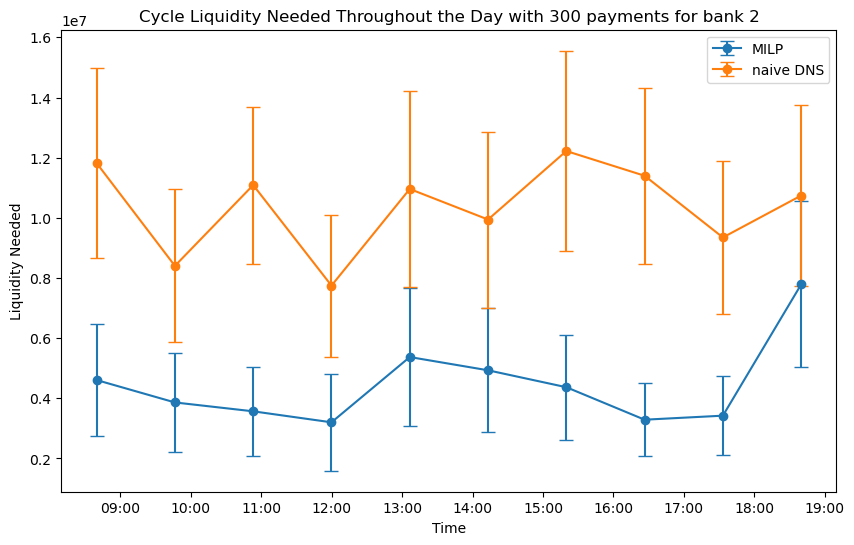

Distribution of cycle liqudity needed (300 payments, bank 3): 
    -0.00          0.10          0.41          0.59          0.82         \
0            66             0             0             0             0   
1            64             0             0             0             0   
2            54             0             0             0             0   
3            62             0             0             0             0   
4            55             0             0             0             0   
5            60             0             0             0             0   
6            56             0             0             0             0   
7            49             0             0             0             1   
8            54             0             1             0             0   
9            46             1             0             1             0   

    0.93          1.20          1.41          1.48          1.53         ...  \
0             0             0 

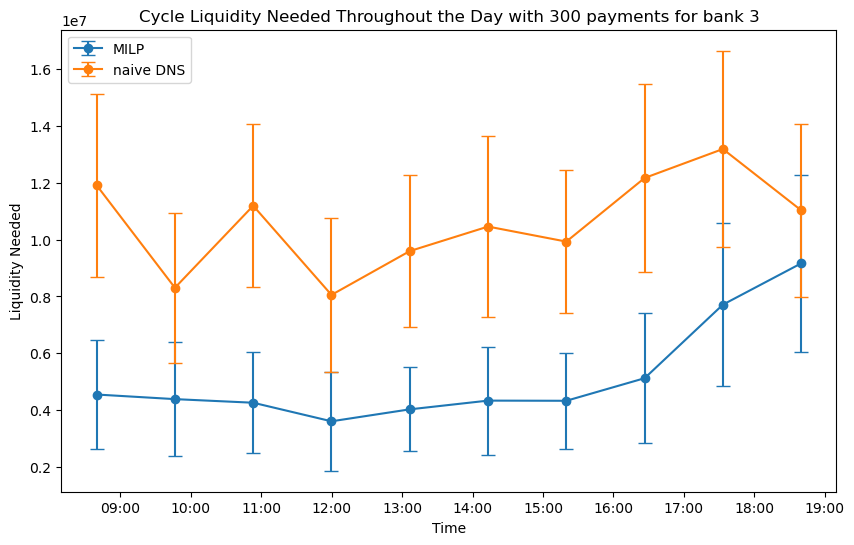

Distribution of cycle liqudity needed (300 payments, bank 4): 
    0.000000e+00  1.776357e-14  1.200000e-01  4.700000e-01  7.600000e-01  \
0            78             0             0             0             0   
1            57             0             0             0             0   
2            59             0             0             0             0   
3            53             1             0             0             0   
4            53             0             1             0             0   
5            59             0             0             1             0   
6            49             0             0             0             0   
7            56             0             0             0             1   
8            56             0             0             0             0   
9            59             0             0             0             0   

   8.300000e-01  1.240000e+00  1.460000e+00  1.980000e+00  2.240000e+00  ...  \
0             0             0 

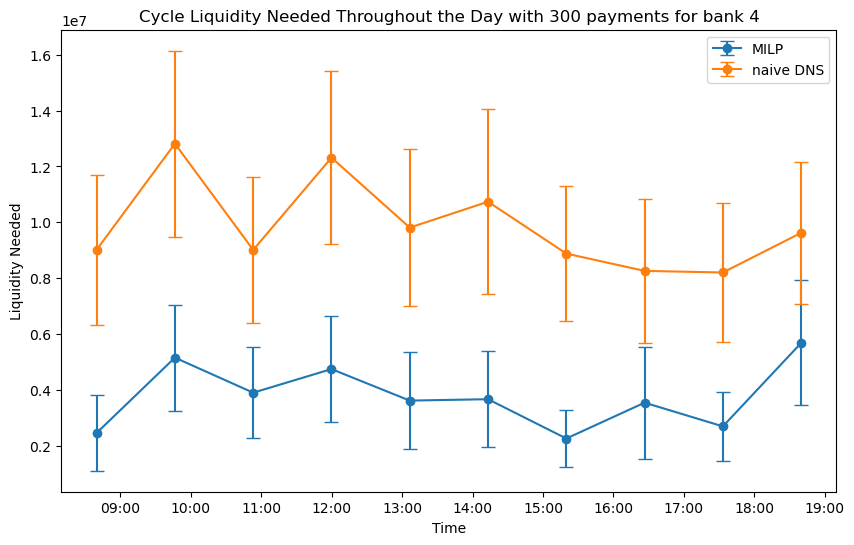

Distribution of cycle liqudity needed (300 payments, bank 5): 
    -0.000000e+00   3.469447e-17   8.000000e-02   1.300000e-01   4.300000e-01  \
0             76              0              0              0              0   
1             69              0              0              0              0   
2             57              0              0              0              0   
3             62              0              0              0              0   
4             59              0              0              0              0   
5             50              1              0              0              0   
6             51              0              0              0              0   
7             59              0              0              1              0   
8             56              0              1              0              0   
9             56              0              0              0              1   

    4.700000e-01   6.300000e-01   7.000000e-01   8.8000

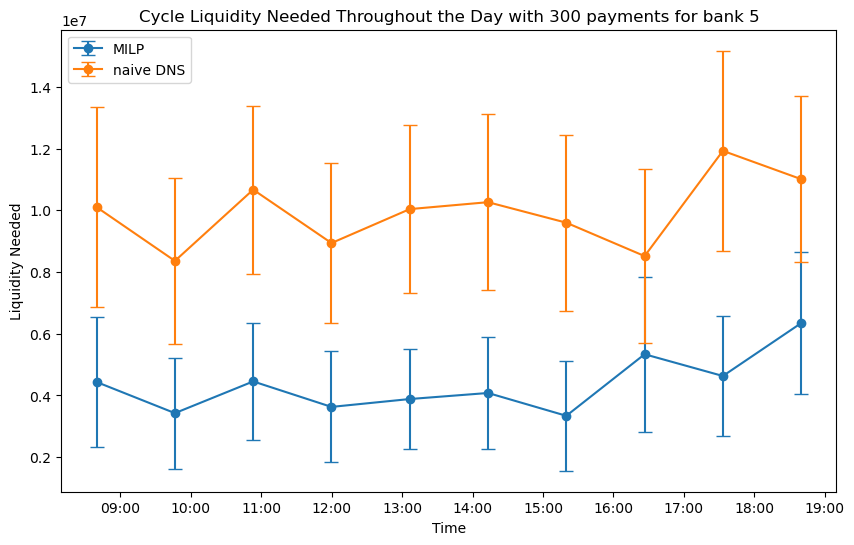

Distribution of cycle liqudity needed (300 payments, bank 6): 
    -0.000000e+00   1.338776e-09   3.500000e-01   4.600000e-01   5.000000e-01  \
0             70              0              0              0              0   
1             54              0              0              0              0   
2             55              1              0              0              0   
3             52              0              0              0              0   
4             57              0              0              0              0   
5             49              0              0              0              0   
6             55              0              0              0              1   
7             50              0              1              0              0   
8             49              0              0              0              0   
9             42              0              0              1              0   

    8.600000e-01   5.370000e+00   6.410000e+00   6.5400

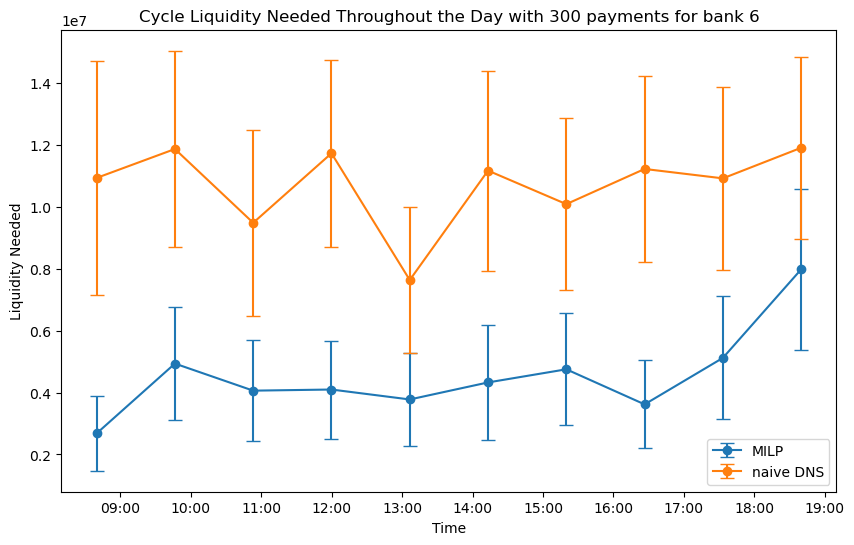

Distribution of cycle liqudity needed (300 payments, bank 7): 
    0.000000e+00  4.656897e-11  9.000000e-02  3.400000e-01  6.400000e-01  \
0            74             0             0             0             0   
1            65             0             0             0             0   
2            66             0             0             0             0   
3            69             1             0             0             0   
4            55             0             0             0             0   
5            57             0             0             1             0   
6            54             0             0             0             0   
7            59             0             0             0             1   
8            52             0             1             0             0   
9            58             0             0             0             0   

   7.700000e-01  3.000000e+00  4.220000e+00  6.380000e+00  7.120000e+00  ...  \
0             0             0 

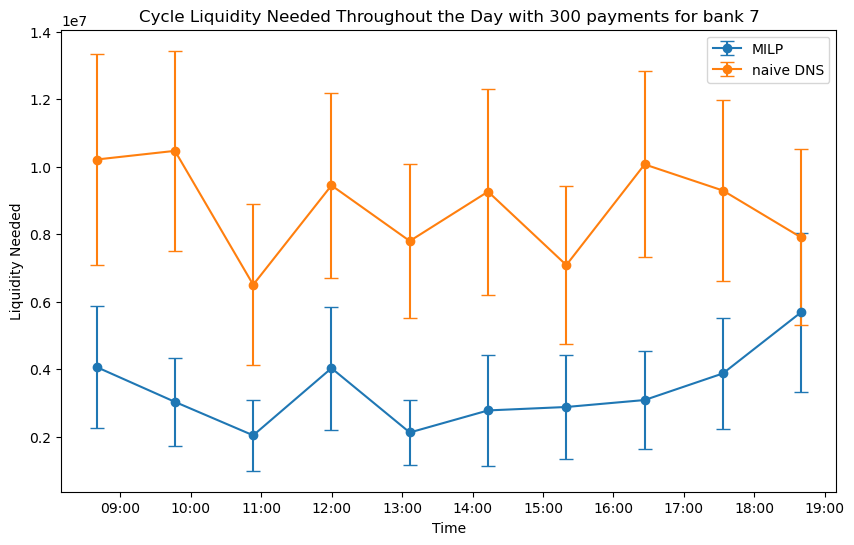

In [7]:
for n in num_payments:
    distribution_df = liquidity_distribution(combined_results['MILP_cycle_liquidity_needed_list_B'][combined_results['number_of_payments'] == n])
    print(f'Distribution of cycle liqudity needed ({n} payments): \n {distribution_df}')

    MILP_cycle_liquidity_needed_mean = combined_results['MILP_cycle_liquidity_needed_list_B'][combined_results['number_of_payments'] == n].apply(pd.Series).mean()
    MILP_cycle_liquidity_needed_sem = combined_results['MILP_cycle_liquidity_needed_list_B'][combined_results['number_of_payments'] == n].apply(pd.Series).sem()

    naive_cycle_liquidity_needed_mean = combined_results['naive_cycle_liquidity_needed_list_B'][combined_results['number_of_payments'] == n].apply(pd.Series).mean()
    naive_cycle_liquidity_needed_sem = combined_results['naive_cycle_liquidity_needed_list_B'][combined_results['number_of_payments'] == n].apply(pd.Series).sem()

    MILP_cycle_liquidity_needed_ci = 1.96 * MILP_cycle_liquidity_needed_sem
    naive_cycle_liquidity_needed_ci = 1.96 * naive_cycle_liquidity_needed_sem

    # Generate time series for x-axis
    base_date = datetime.today()
    time_series = [base_date.replace(hour=8) + timedelta(hours=i) for i in np.linspace(0, 10, num=10)]

    # Plot the data with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(time_series, MILP_cycle_liquidity_needed_mean, yerr=MILP_cycle_liquidity_needed_ci,
                 marker='o', label='MILP', capsize=5)
    plt.errorbar(time_series, naive_cycle_liquidity_needed_mean, yerr=naive_cycle_liquidity_needed_ci,
                 marker='o', label='naive DNS', capsize=5)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Time')
    plt.ylabel('Liquidity Needed')
    plt.title(f'Cycle Liquidity Needed Throughout the Day with {n} payments')
    plt.legend()
    plt.show()
    for p in range(num_banks):
        distribution_df = liquidity_distribution(combined_results_participant['MILP_cycle_liquidity_needed_list_B'][(combined_results_participant['number_of_payments'] == n) & (combined_results_participant['participant'] == f"data_{p}")])
        print(f'Distribution of cycle liqudity needed ({n} payments, bank {p}): \n {distribution_df}')
        
        MILP_cycle_liquidity_needed_mean = combined_results_participant['MILP_cycle_liquidity_needed_list_B'][(combined_results_participant['number_of_payments'] == n) & (combined_results_participant['participant'] == f"data_{p}")].apply(pd.Series).mean()
        MILP_cycle_liquidity_needed_sem = combined_results_participant['MILP_cycle_liquidity_needed_list_B'][(combined_results_participant['number_of_payments'] == n) & (combined_results_participant['participant'] == f"data_{p}")].apply(pd.Series).sem()

        naive_cycle_liquidity_needed_mean = combined_results_participant['naive_cycle_liquidity_needed_list_B'][(combined_results_participant['number_of_payments'] == n) & (combined_results_participant['participant'] == f"data_{p}")].apply(pd.Series).mean()
        naive_cycle_liquidity_needed_sem = combined_results_participant['naive_cycle_liquidity_needed_list_B'][(combined_results_participant['number_of_payments'] == n) & (combined_results_participant['participant'] == f"data_{p}")].apply(pd.Series).sem()

        MILP_cycle_liquidity_needed_ci = 1.96 * MILP_cycle_liquidity_needed_sem
        naive_cycle_liquidity_needed_ci = 1.96 * naive_cycle_liquidity_needed_sem

        # Generate time series for x-axis
        base_date = datetime.today()
        time_series = [base_date.replace(hour=8) + timedelta(hours=i) for i in np.linspace(0, 10, num=10)]

        # Plot the data with error bars
        plt.figure(figsize=(10, 6))
        plt.errorbar(time_series, MILP_cycle_liquidity_needed_mean, yerr=MILP_cycle_liquidity_needed_ci,
                     marker='o', label='MILP', capsize=5)
        plt.errorbar(time_series, naive_cycle_liquidity_needed_mean, yerr=naive_cycle_liquidity_needed_ci,
                     marker='o', label='naive DNS', capsize=5)

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        plt.xlabel('Time')
        plt.ylabel('Liquidity Needed')
        plt.title(f'Cycle Liquidity Needed Throughout the Day with {n} payments for bank {p}')
        plt.legend()
        plt.show()

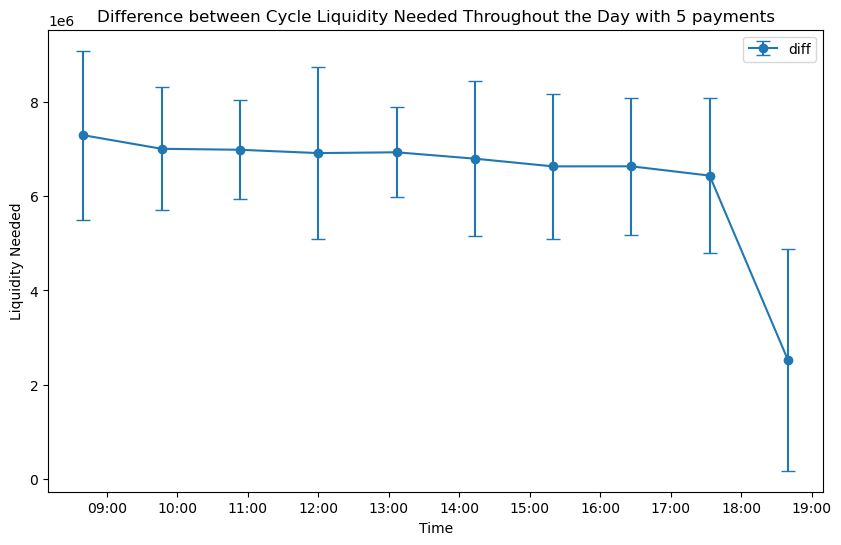

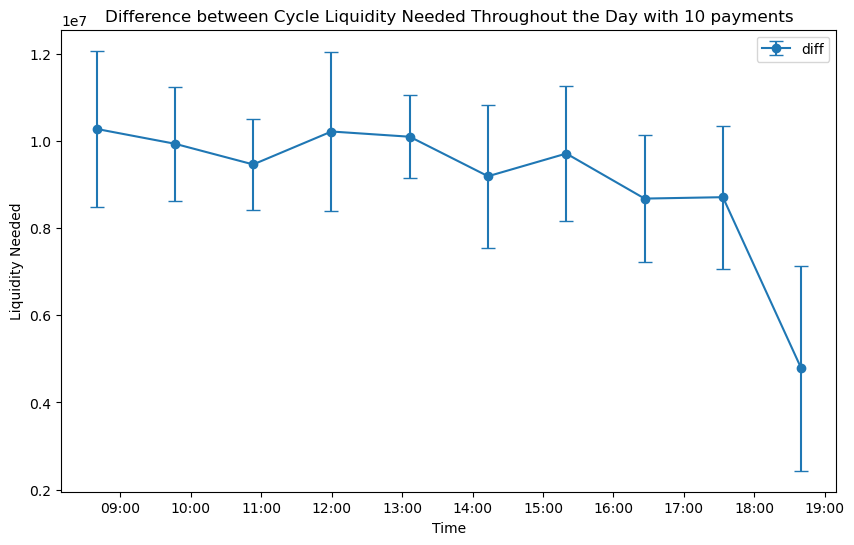

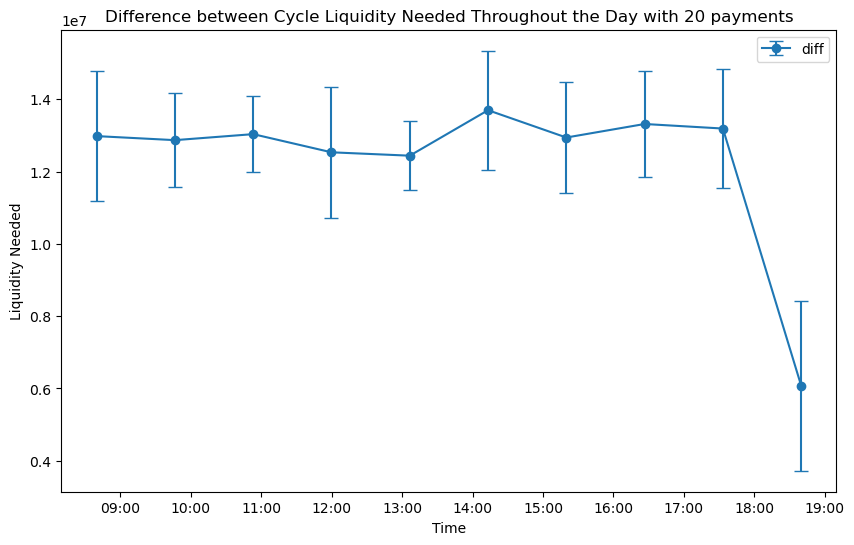

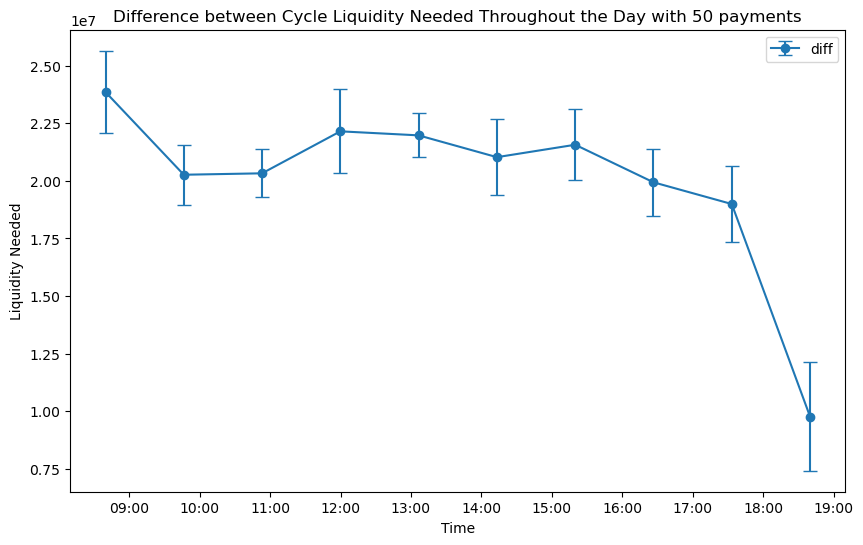

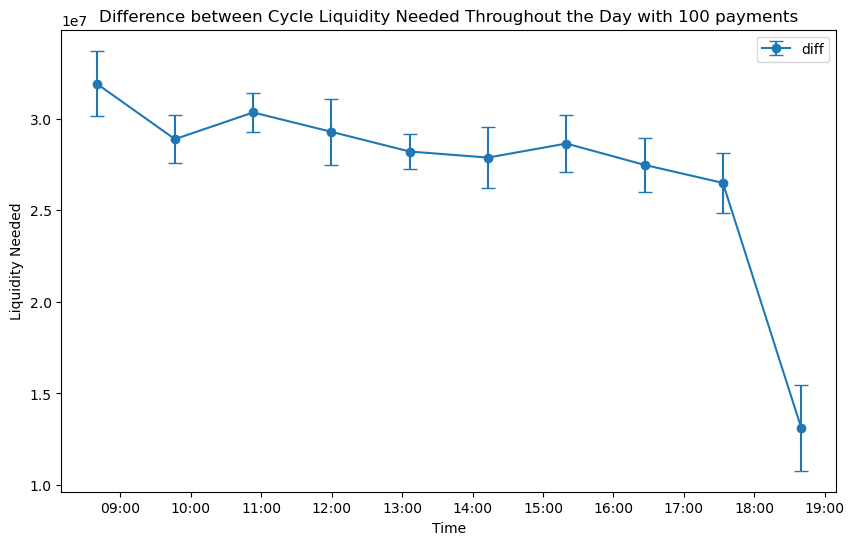

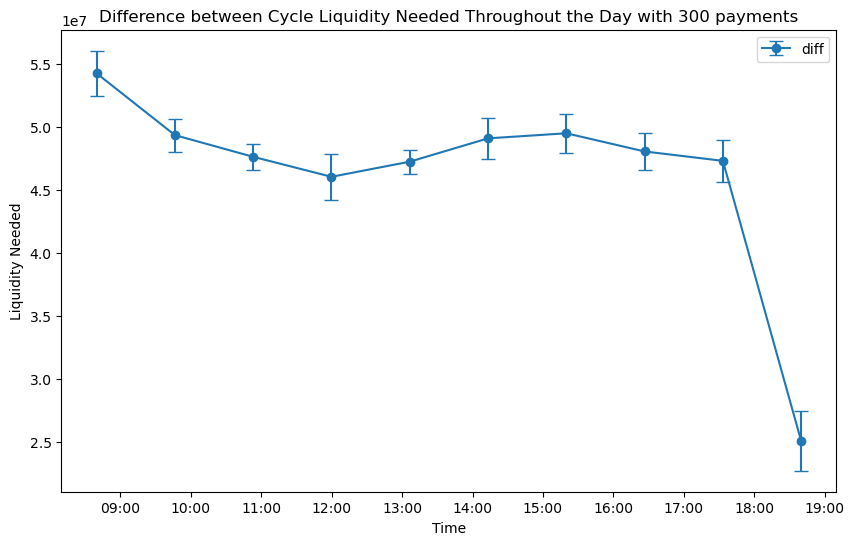

In [8]:
for n in num_payments:
    diff_cycle_liquidity_needed_mean = combined_results['diff_liquidity_needed_B'][combined_results['number_of_payments'] == n].apply(pd.Series).mean()
    diff_cycle_liquidity_needed_sem = combined_results['diff_liquidity_needed_B'][combined_results['number_of_payments'] == n].apply(pd.Series).sem()

    diff_cycle_liquidity_needed_ci = 1.96 * diff_cycle_liquidity_needed_sem

    # Generate time series for x-axis
    base_date = datetime.today()
    time_series = [base_date.replace(hour=8) + timedelta(hours=i) for i in np.linspace(0, 10, num=10)]

    # Plot the data with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(time_series, diff_cycle_liquidity_needed_mean, yerr=MILP_cycle_liquidity_needed_ci,
                 marker='o', label='diff', capsize=5)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Time')
    plt.ylabel('Liquidity Needed')
    plt.title(f'Difference between Cycle Liquidity Needed Throughout the Day with {n} payments')
    plt.legend()
    plt.show()

In [9]:
num_days = 100

combined_results_participant = combined_results_participant[[
        'total_volume_A', 'total_value_A', 'system_start_of_day_balance_A', 'system_net_liquidity_A', 'system_lnncp_liquidity_A', 
        'system_MILP_liquidity_A', 'volume_settled_A', 'value_settled_A', 'system_net_liquidity_pct_A', 'system_lnncp_liquidity_pct_A', 
        'system_MILP_liquidity_pct_A', 'volume_rejected_A', 'value_rejected_A', 'sum_delays_A', 'avg_delay_A', 'median_delay_A', 
        '5th_percentile_delay_A', '95th_percentile_delay_A', 'naive_delay_A', 'naive_lnncp_A', 'system_naive_liquidity_pct_A',
        'total_volume_B', 'total_value_B', 'system_start_of_day_balance_B', 'system_net_liquidity_B', 'system_lnncp_liquidity_B', 
        'system_MILP_liquidity_B', 'volume_settled_B', 'value_settled_B', 'system_net_liquidity_pct_B', 'system_lnncp_liquidity_pct_B', 
        'system_MILP_liquidity_pct_B', 'volume_rejected_B', 'value_rejected_B', 'sum_delays_B', 'avg_delay_B', 'median_delay_B', 
        '5th_percentile_delay_B', '95th_percentile_delay_B', 'naive_delay_B', 'naive_lnncp_B', 'system_naive_liquidity_pct_B',
        '95th_percentile_DNS_delay','DNS_delay', '95th_percentile_naive_delay', 'naive_avg_delay', 'number_of_payments', 'participant'
]]

combined_results = combined_results[[
        'total_volume_A', 'total_value_A', 'system_start_of_day_balance_A', 'system_net_liquidity_A', 'system_lnncp_liquidity_A', 
        'system_MILP_liquidity_A', 'volume_settled_A', 'value_settled_A', 'system_net_liquidity_pct_A', 'system_lnncp_liquidity_pct_A', 
        'system_MILP_liquidity_pct_A', 'volume_rejected_A', 'value_rejected_A', 'sum_delays_A', 'avg_delay_A', 'median_delay_A', 
        '5th_percentile_delay_A', '95th_percentile_delay_A', 'naive_delay_A', 'naive_lnncp_A', 'system_naive_liquidity_pct_A',
        'total_volume_B', 'total_value_B', 'system_start_of_day_balance_B', 'system_net_liquidity_B', 'system_lnncp_liquidity_B', 
        'system_MILP_liquidity_B', 'volume_settled_B', 'value_settled_B', 'system_net_liquidity_pct_B', 'system_lnncp_liquidity_pct_B', 
        'system_MILP_liquidity_pct_B', 'volume_rejected_B', 'value_rejected_B', 'sum_delays_B', 'avg_delay_B', 'median_delay_B', 
        '5th_percentile_delay_B', '95th_percentile_delay_B', 'naive_delay_B', 'naive_lnncp_B', 'system_naive_liquidity_pct_B',
        '95th_percentile_DNS_delay', 'DNS_delay', '95th_percentile_naive_delay', 'naive_avg_delay', 'number_of_payments',
        'avg_cycle_running_time'
]]

grouped = combined_results.groupby('number_of_payments').agg(['mean', 'std'])
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
ci95 = 1.96 * grouped.filter(like='std') / np.sqrt(num_days)
ci95.columns = ci95.columns.str.replace('std', 'ci95_')

ci_median_delay_A = {}
ci_5th_percentile_delay_A = {}
ci_95th_percentile_delay_A = {}
ci_median_delay_B = {}
ci_5th_percentile_delay_B = {}
ci_95th_percentile_delay_B = {}
ci_95th_percentile_DNS_delay = {}
ci_95th_percentile_naive_delay = {}

# Calculate bootstrap CIs for each unique number_of_payments
for num_payments in combined_results['number_of_payments'].unique():
    subset = combined_results[combined_results['number_of_payments'] == num_payments]
    ci_median_delay_A[num_payments] = bootstrap_ci(subset['median_delay_A'])
    ci_5th_percentile_delay_A[num_payments] = bootstrap_ci(subset['5th_percentile_delay_A'])
    ci_95th_percentile_delay_A[num_payments] = bootstrap_ci(subset['95th_percentile_delay_A'])
    ci_median_delay_B[num_payments] = bootstrap_ci(subset['median_delay_B'])
    ci_5th_percentile_delay_B[num_payments] = bootstrap_ci(subset['5th_percentile_delay_B'])
    ci_95th_percentile_delay_B[num_payments] = bootstrap_ci(subset['95th_percentile_delay_B'])
    ci_95th_percentile_DNS_delay[num_payments] = bootstrap_ci(subset['95th_percentile_DNS_delay'])
    ci_95th_percentile_naive_delay[num_payments] = bootstrap_ci(subset['95th_percentile_naive_delay'])

# Replace CI values in the metrics DataFrame
metrics = grouped.filter(like='mean').join(ci95)
metrics.reset_index(inplace=True)

# Add bootstrapped CIs to the metrics DataFrame
metrics['median_delay_A_ci95_'] = metrics['number_of_payments'].map(ci_median_delay_A)
metrics['5th_percentile_delay_A_ci95_'] = metrics['number_of_payments'].map(ci_5th_percentile_delay_A)
metrics['95th_percentile_delay_A_ci95_'] = metrics['number_of_payments'].map(ci_95th_percentile_delay_A)
metrics['median_delay_B_ci95_'] = metrics['number_of_payments'].map(ci_median_delay_B)
metrics['5th_percentile_delay_B_ci95_'] = metrics['number_of_payments'].map(ci_5th_percentile_delay_B)
metrics['95th_percentile_delay_B_ci95_'] = metrics['number_of_payments'].map(ci_95th_percentile_delay_B)
metrics['95th_percentile_DNS_delay_ci95_'] = metrics['number_of_payments'].map(ci_95th_percentile_DNS_delay)
metrics['95th_percentile_naive_delay_ci95_'] = metrics['number_of_payments'].map(ci_95th_percentile_naive_delay)

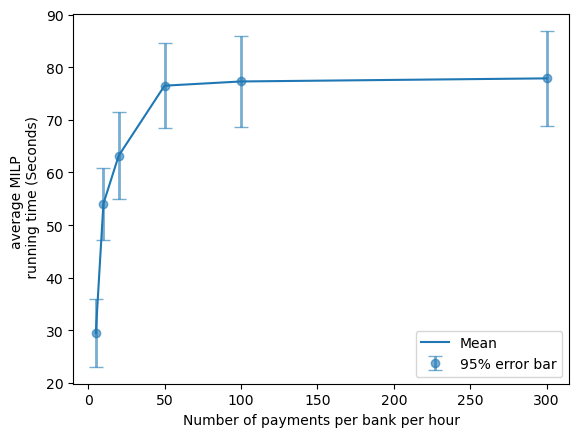

In [10]:
metrics_to_plot = 'avg_cycle_running_time'
y_labels = 'average MILP \n running time (Seconds)'

plt.plot(
    metrics['number_of_payments'], metrics[f'{metrics_to_plot}_mean'], label='Mean', color='#1f77b4'
)
ci_col = f'{metrics_to_plot}_ci95_'
ci_lower = metrics[ci_col]
ci_upper = metrics[ci_col]
plt.errorbar(
    metrics['number_of_payments'],
    metrics[f'{metrics_to_plot}_mean'],
    yerr=[ci_lower, ci_upper],
    fmt='o',
    ecolor='#1f77b4',
    color='#1f77b4',
    elinewidth=2,
    capsize=5,
    alpha=0.6,
    label='95% error bar'
)

plt.xlabel('Number of payments per bank per hour')
plt.ylabel(y_labels)
plt.legend()
plt.show()

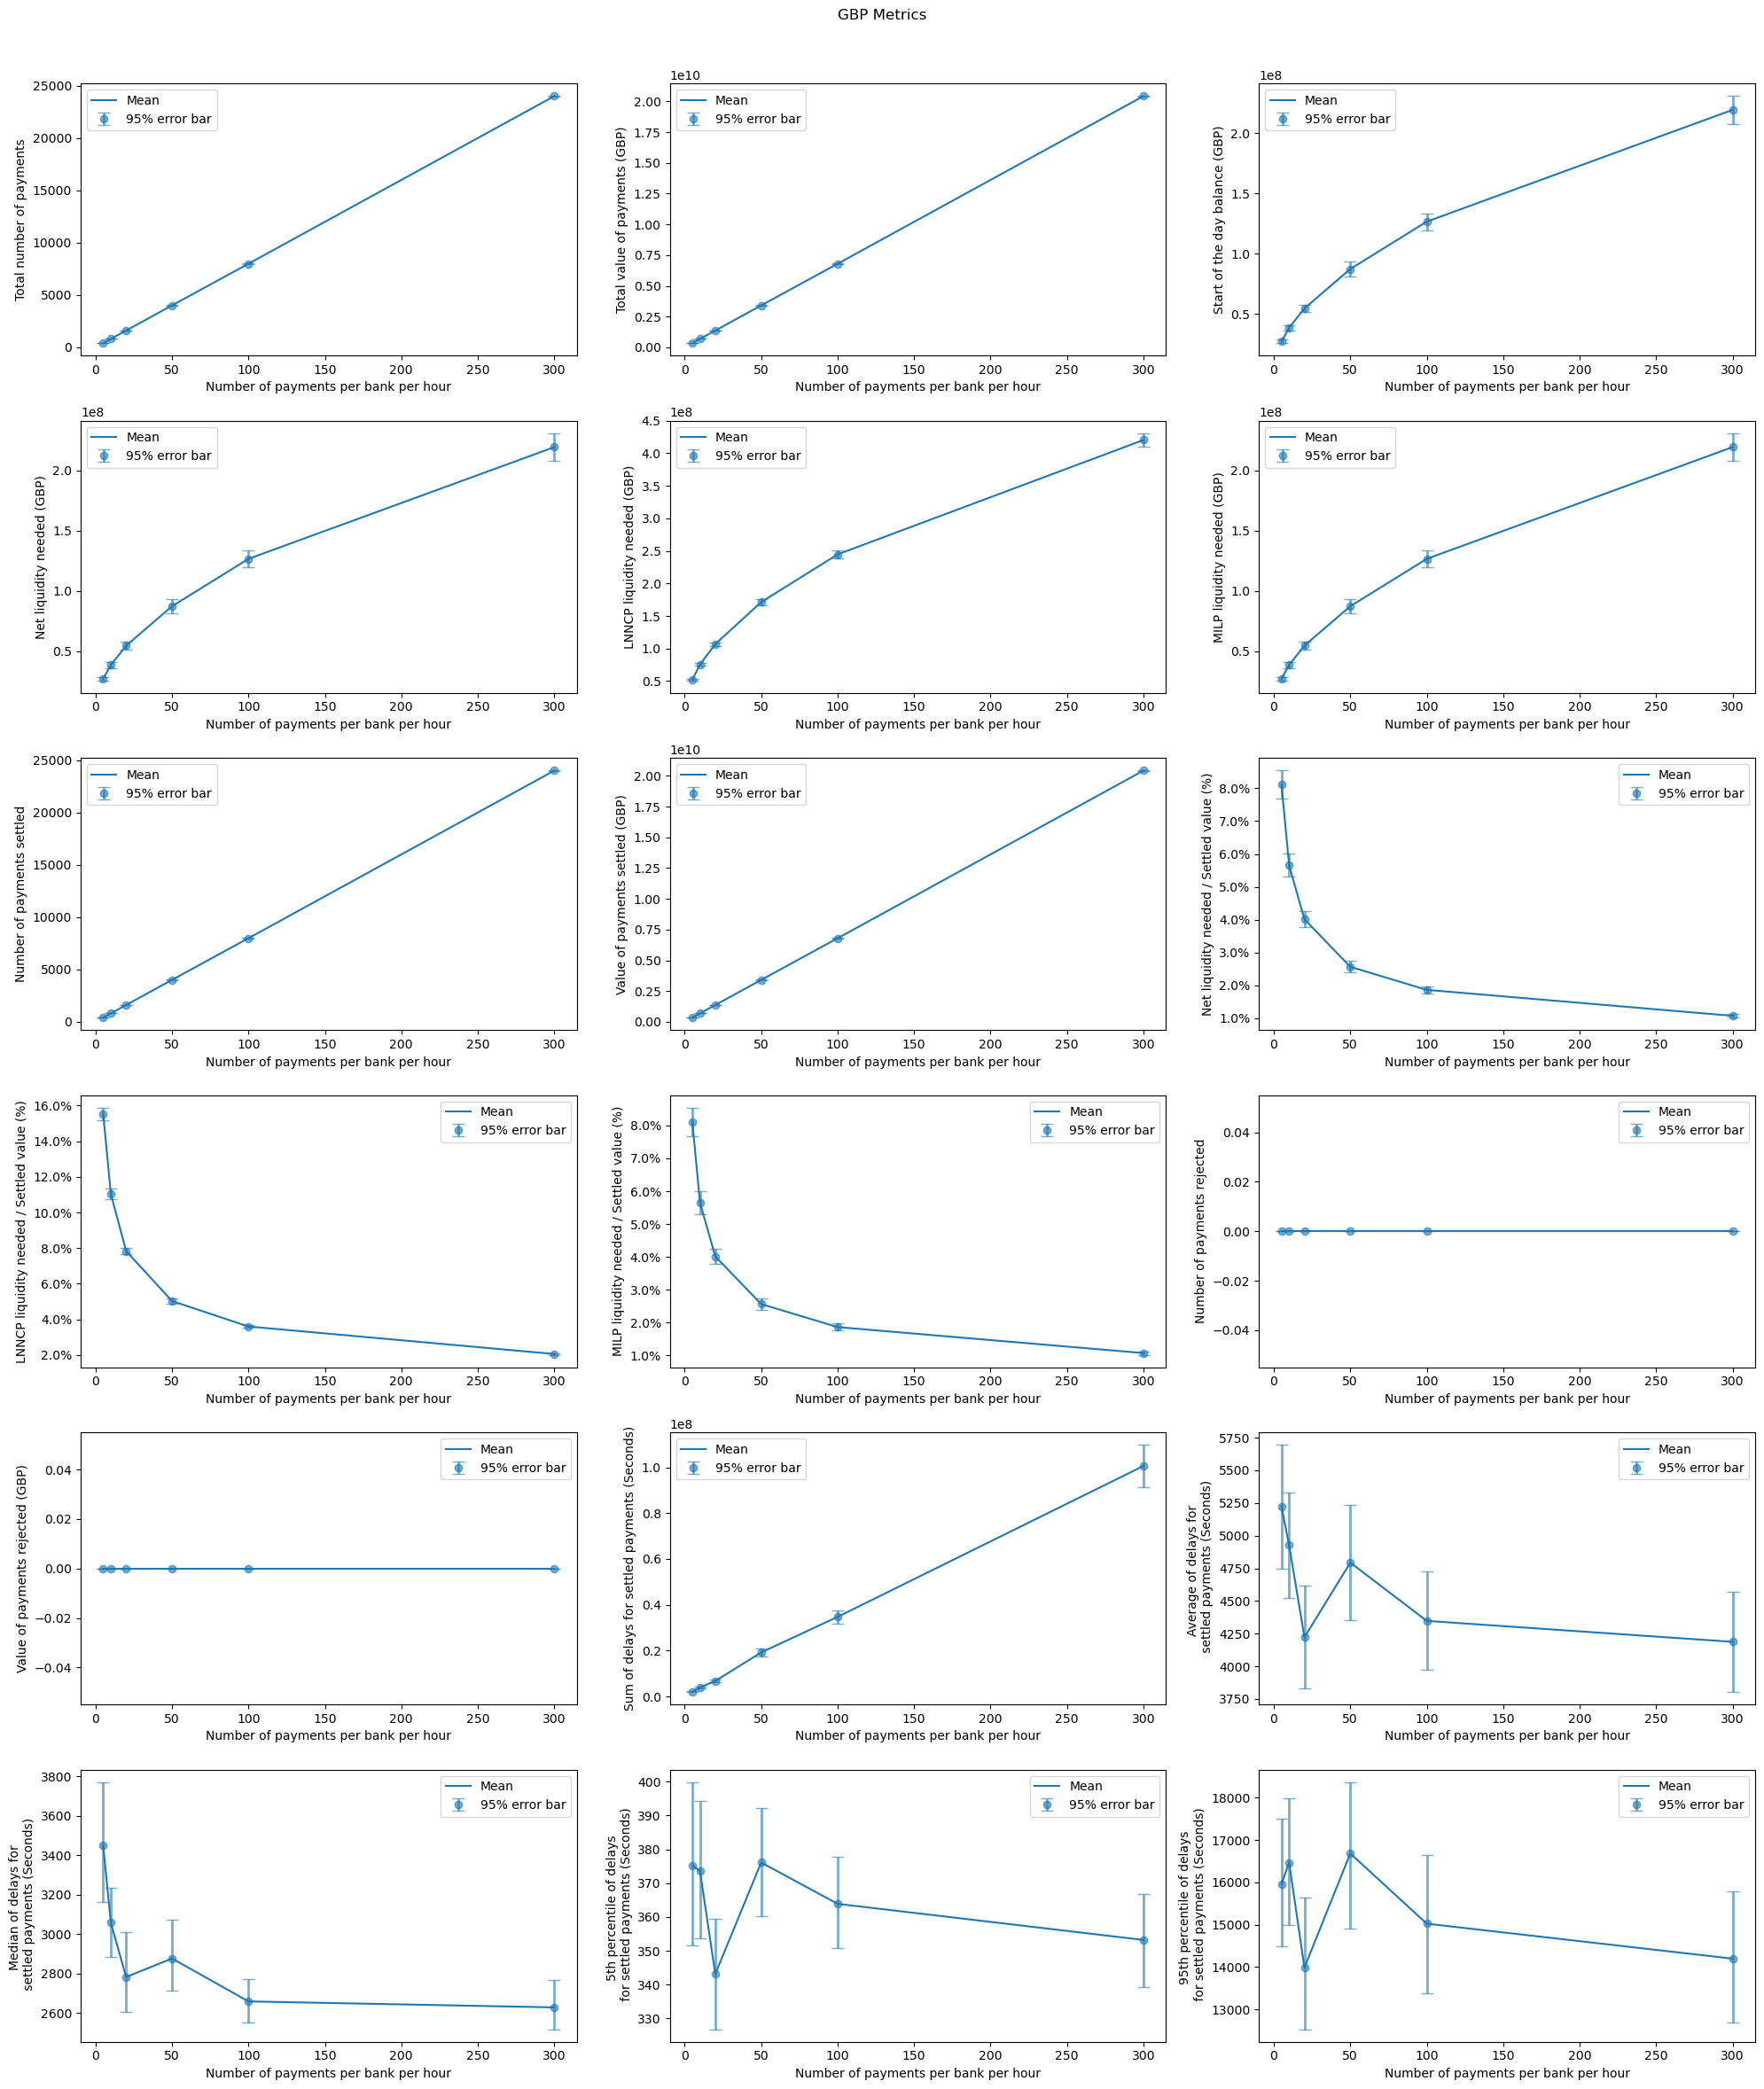

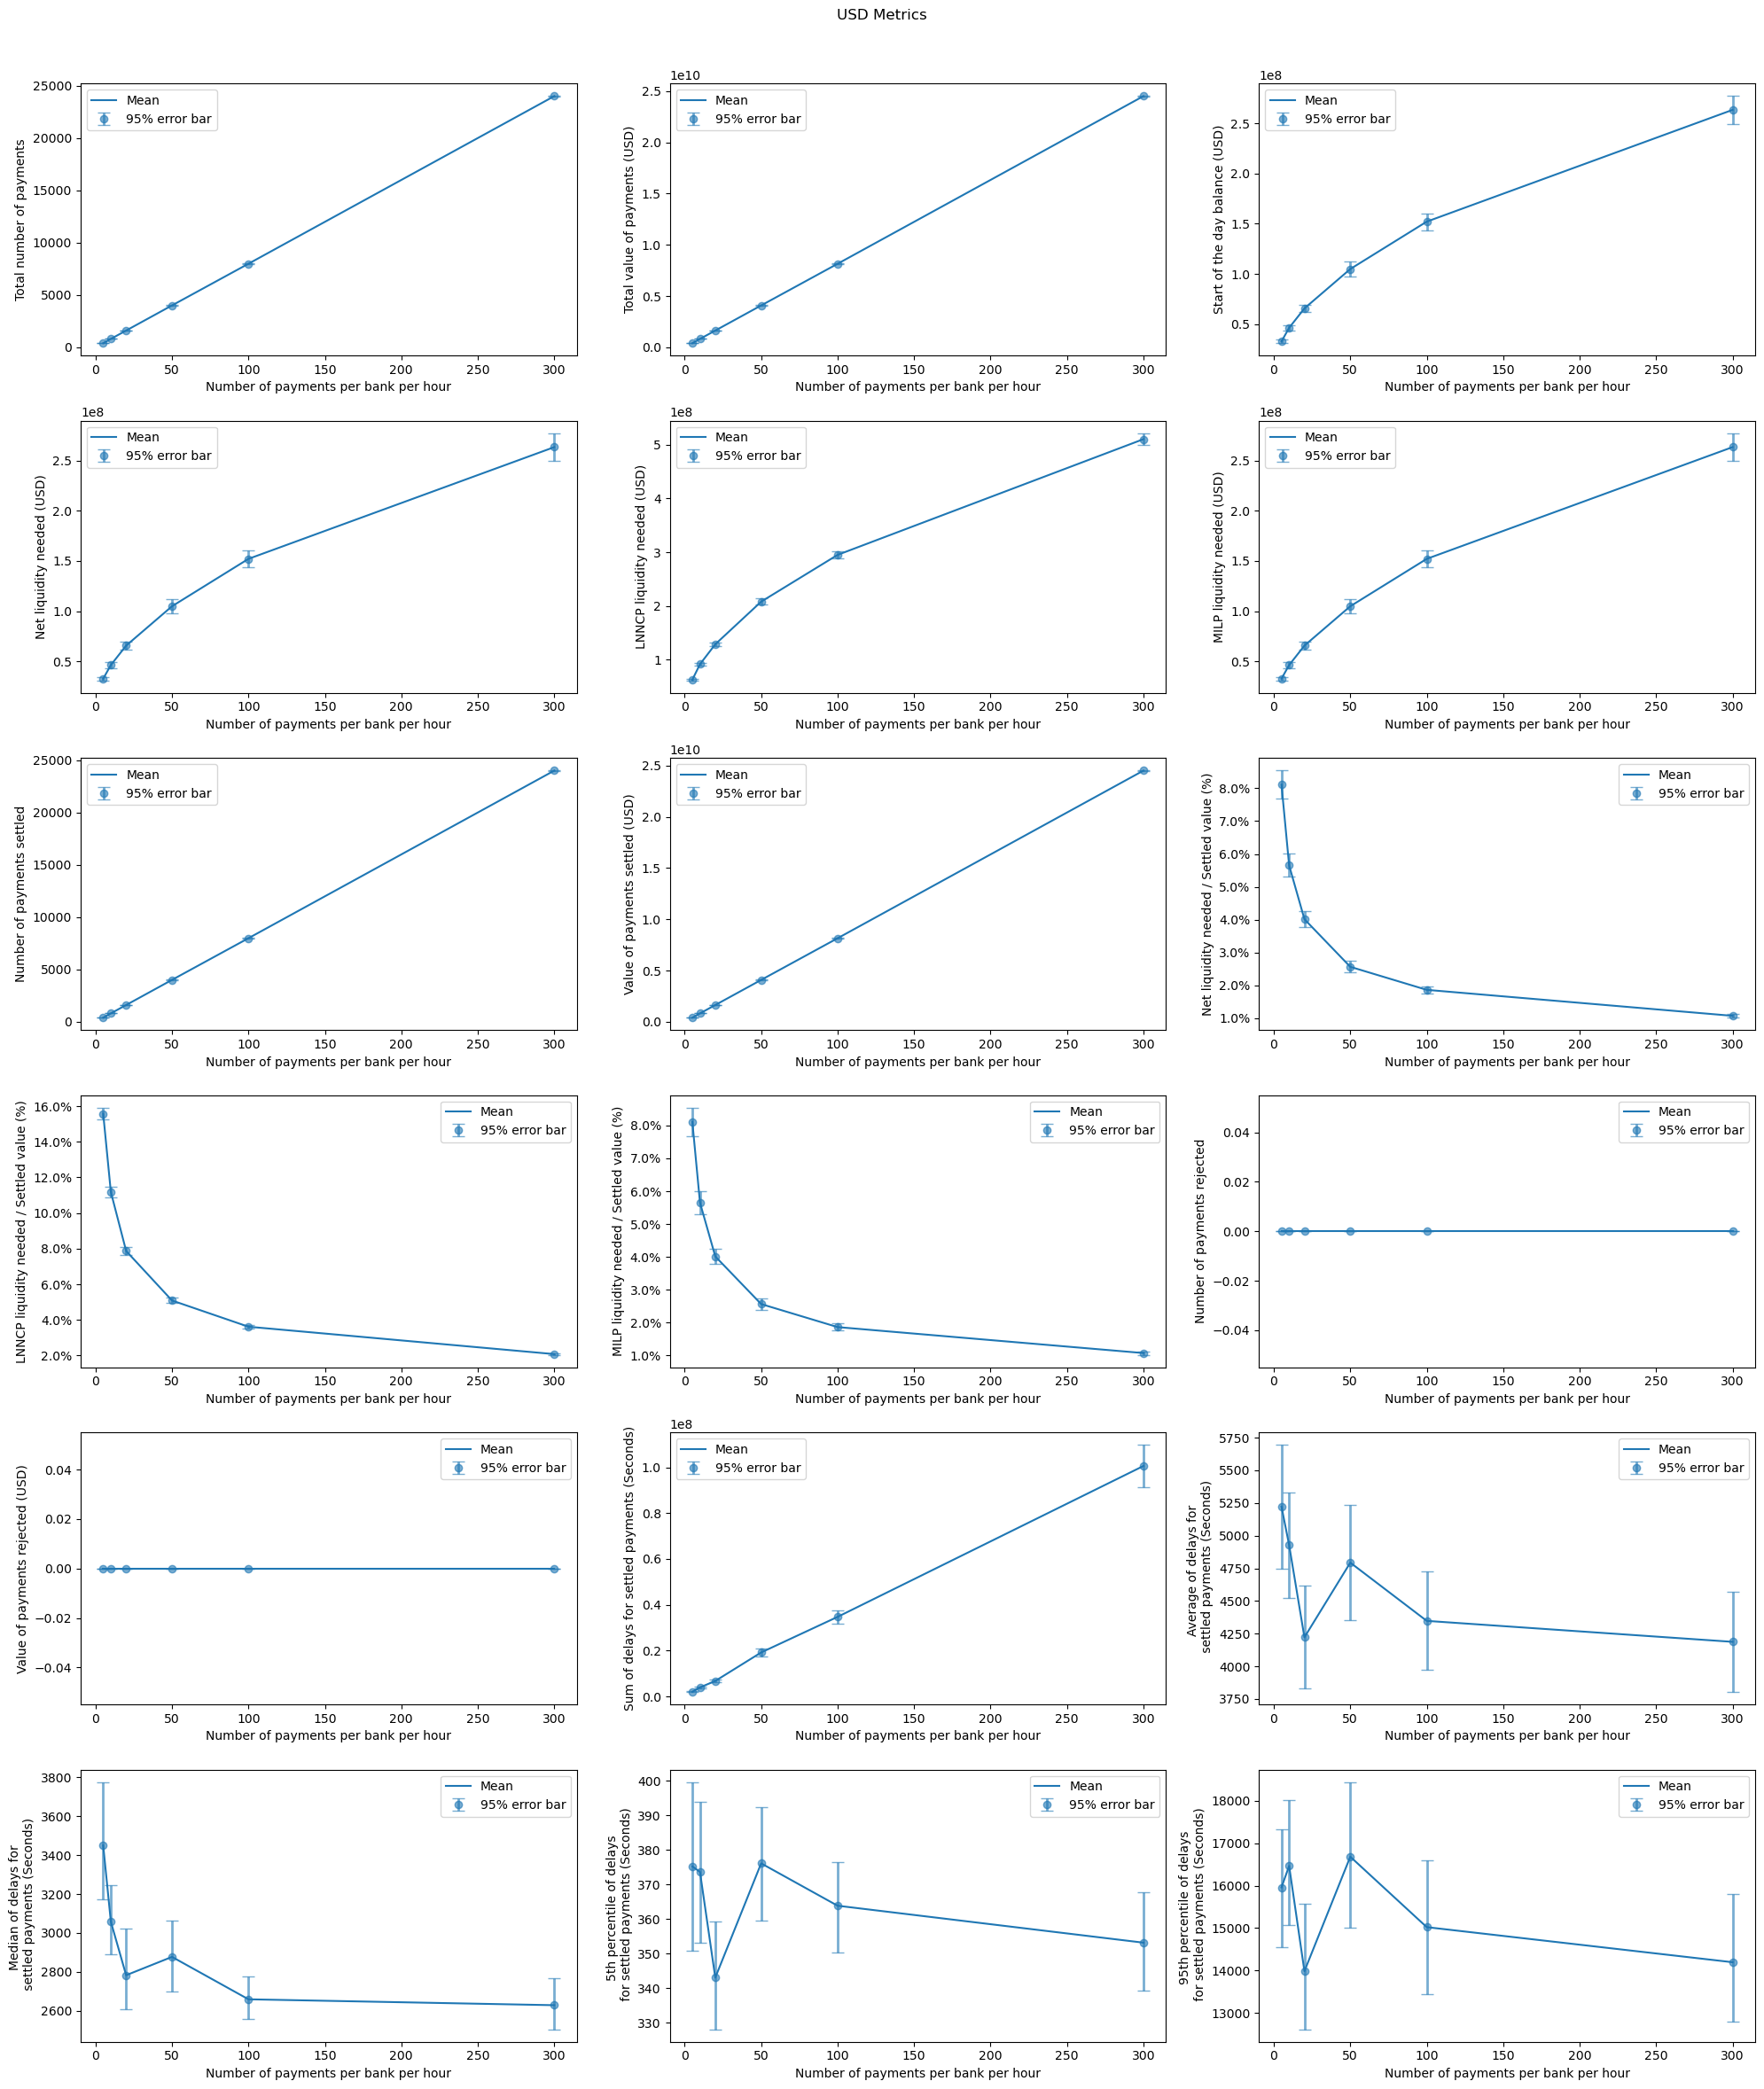

In [11]:
plot_increase_num_payments(metrics)

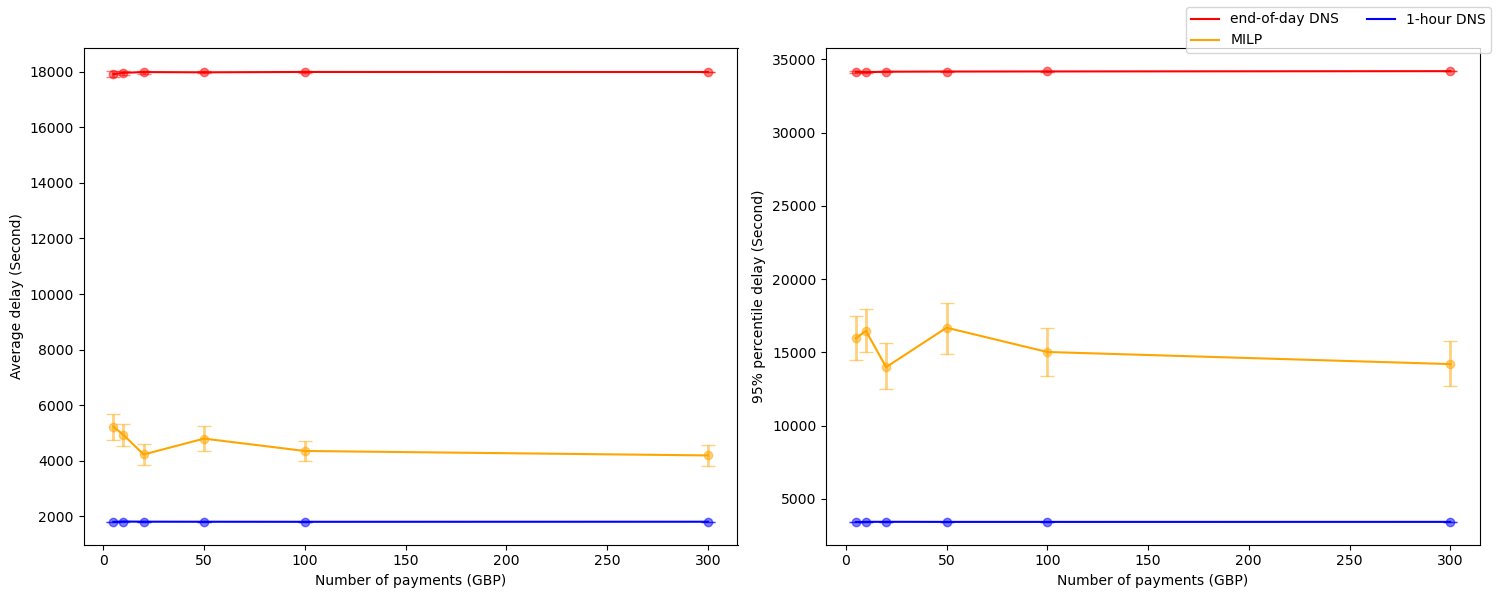

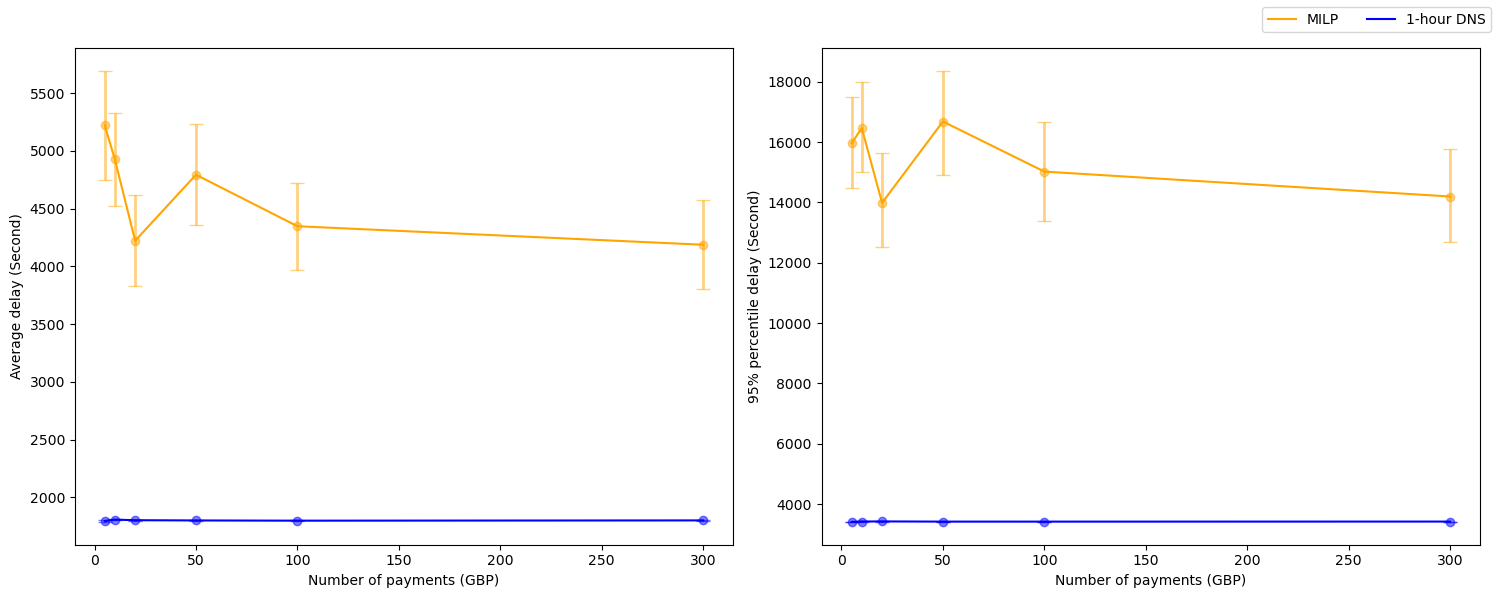

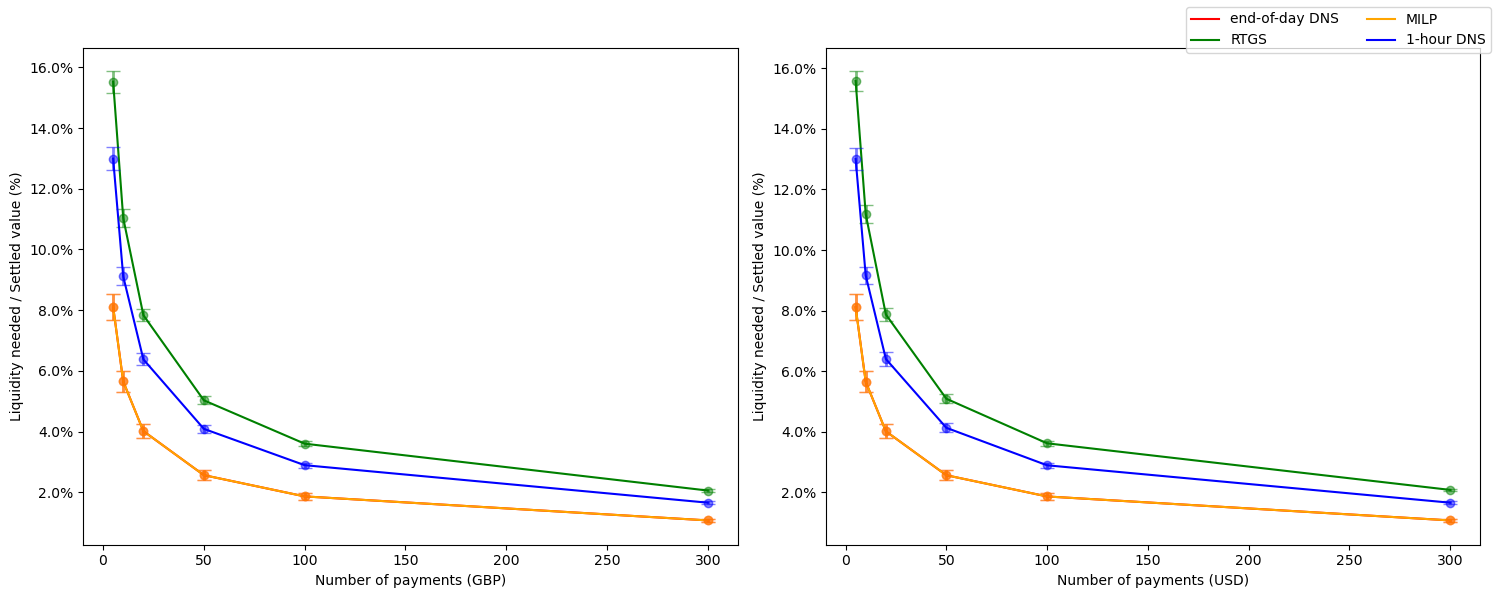

In [12]:
plot_delay(metrics)
plot_delay_extract(metrics)
plot_liquidity_pct(metrics)

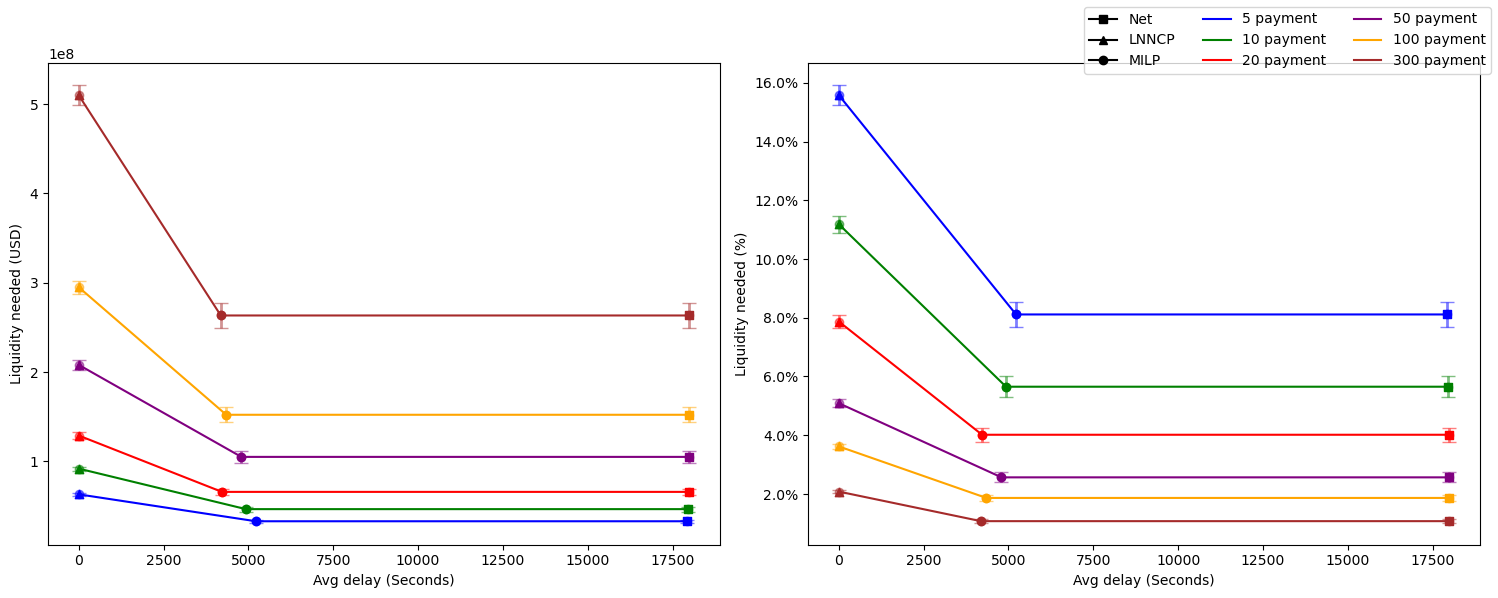

In [13]:
num_payments = [5, 10, 20, 50, 100, 300]

mechanisms = ['lnncp', 'MILP', 'net']
color_dict = {
    5: 'blue',
    10: 'green',
    20: 'red',
    50: 'purple',
    100: 'orange',
    300: 'brown'
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for index, num_payment in enumerate(num_payments):
    x_values = []
    y_values1 = []
    y_values2 = []
    ci1 = []
    ci2 = []
    row = metrics[metrics['number_of_payments'] == num_payment]
    for i, mechanism in enumerate(mechanisms):
        y_value1 = np.mean(combined_results[combined_results['number_of_payments']==num_payment][f'system_{mechanism}_liquidity_B'])
        y_value2 = np.mean(combined_results[combined_results['number_of_payments']==num_payment][f'system_{mechanism}_liquidity_pct_B'])
        if mechanism == 'MILP':
            x_value = np.mean(combined_results[combined_results['number_of_payments']==num_payment][f'avg_delay_B'])
            ax1.scatter(x_value, y_value1, color=color_dict[num_payment], marker="o")
            ax2.scatter(x_value, y_value2, color=color_dict[num_payment], marker="o")
        elif mechanism == 'net':
            x_value = np.mean(combined_results[combined_results['number_of_payments']==num_payment][f'DNS_delay'])
            ax1.scatter(x_value, y_value1, color=color_dict[num_payment], marker="s")
            ax2.scatter(x_value, y_value2, color=color_dict[num_payment], marker="s")
        elif mechanism == 'lnncp':
            x_value = 0
            ax1.scatter(x_value, y_value1, color=color_dict[num_payment], marker="^")
            ax2.scatter(x_value, y_value2, color=color_dict[num_payment], marker="^")

        ci1.append(float(row[f'system_{mechanism}_liquidity_B_ci95_']))
        ci2.append(float(row[f'system_{mechanism}_liquidity_pct_B_ci95_']))
        x_values.append(x_value)
        y_values1.append(y_value1)
        y_values2.append(y_value2)

    ax1.plot(x_values, y_values1, label=f'{num_payment} payments', color=color_dict[num_payment])
    ax2.plot(x_values, y_values2, label=f'{num_payment} payments', color=color_dict[num_payment])
    ax1.errorbar(
                x_values,
                y_values1,
                yerr=[ci1, ci1],
                fmt='o',
                color=color_dict[num_payment],
                ecolor=color_dict[num_payment],
                elinewidth=2,
                capsize=5,
                alpha=0.5,
                label='95% error bar')
    ax2.errorbar(
                x_values,
                y_values2,
                yerr=[ci2, ci2],
                fmt='o',
                color=color_dict[num_payment],
                ecolor=color_dict[num_payment],
                elinewidth=2,
                capsize=5,
                alpha=0.5,
                label='95% error bar')

ax1.set_xlabel('Avg delay (Seconds)')
ax1.set_ylabel('Liquidity needed (USD)')
ax2.set_xlabel('Avg delay (Seconds)')
ax2.set_ylabel('Liquidity needed (%)')
ax2.yaxis.set_major_formatter(PercentFormatter(1))

# Custom legend
custom_labels = {
    'net': ('s', 'black', 'Net'),
    'lnncp': ('^', 'black', 'LNNCP'),
    'MILP': ('o', 'black', 'MILP')
}
handles = []
labels = []
for mechanism, (marker, color, label) in custom_labels.items():
    handle = plt.Line2D([], [], color='black', marker=marker, label=label)
    handles.append(handle)
    labels.append(label)
for num_payment, color in color_dict.items():
    handle = plt.Line2D([], [], color=color, label=f'{num_payment} payment')
    handles.append(handle)
    labels.append(f'{num_payment} payment')

fig.legend(handles=handles, labels=labels, loc='upper right', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

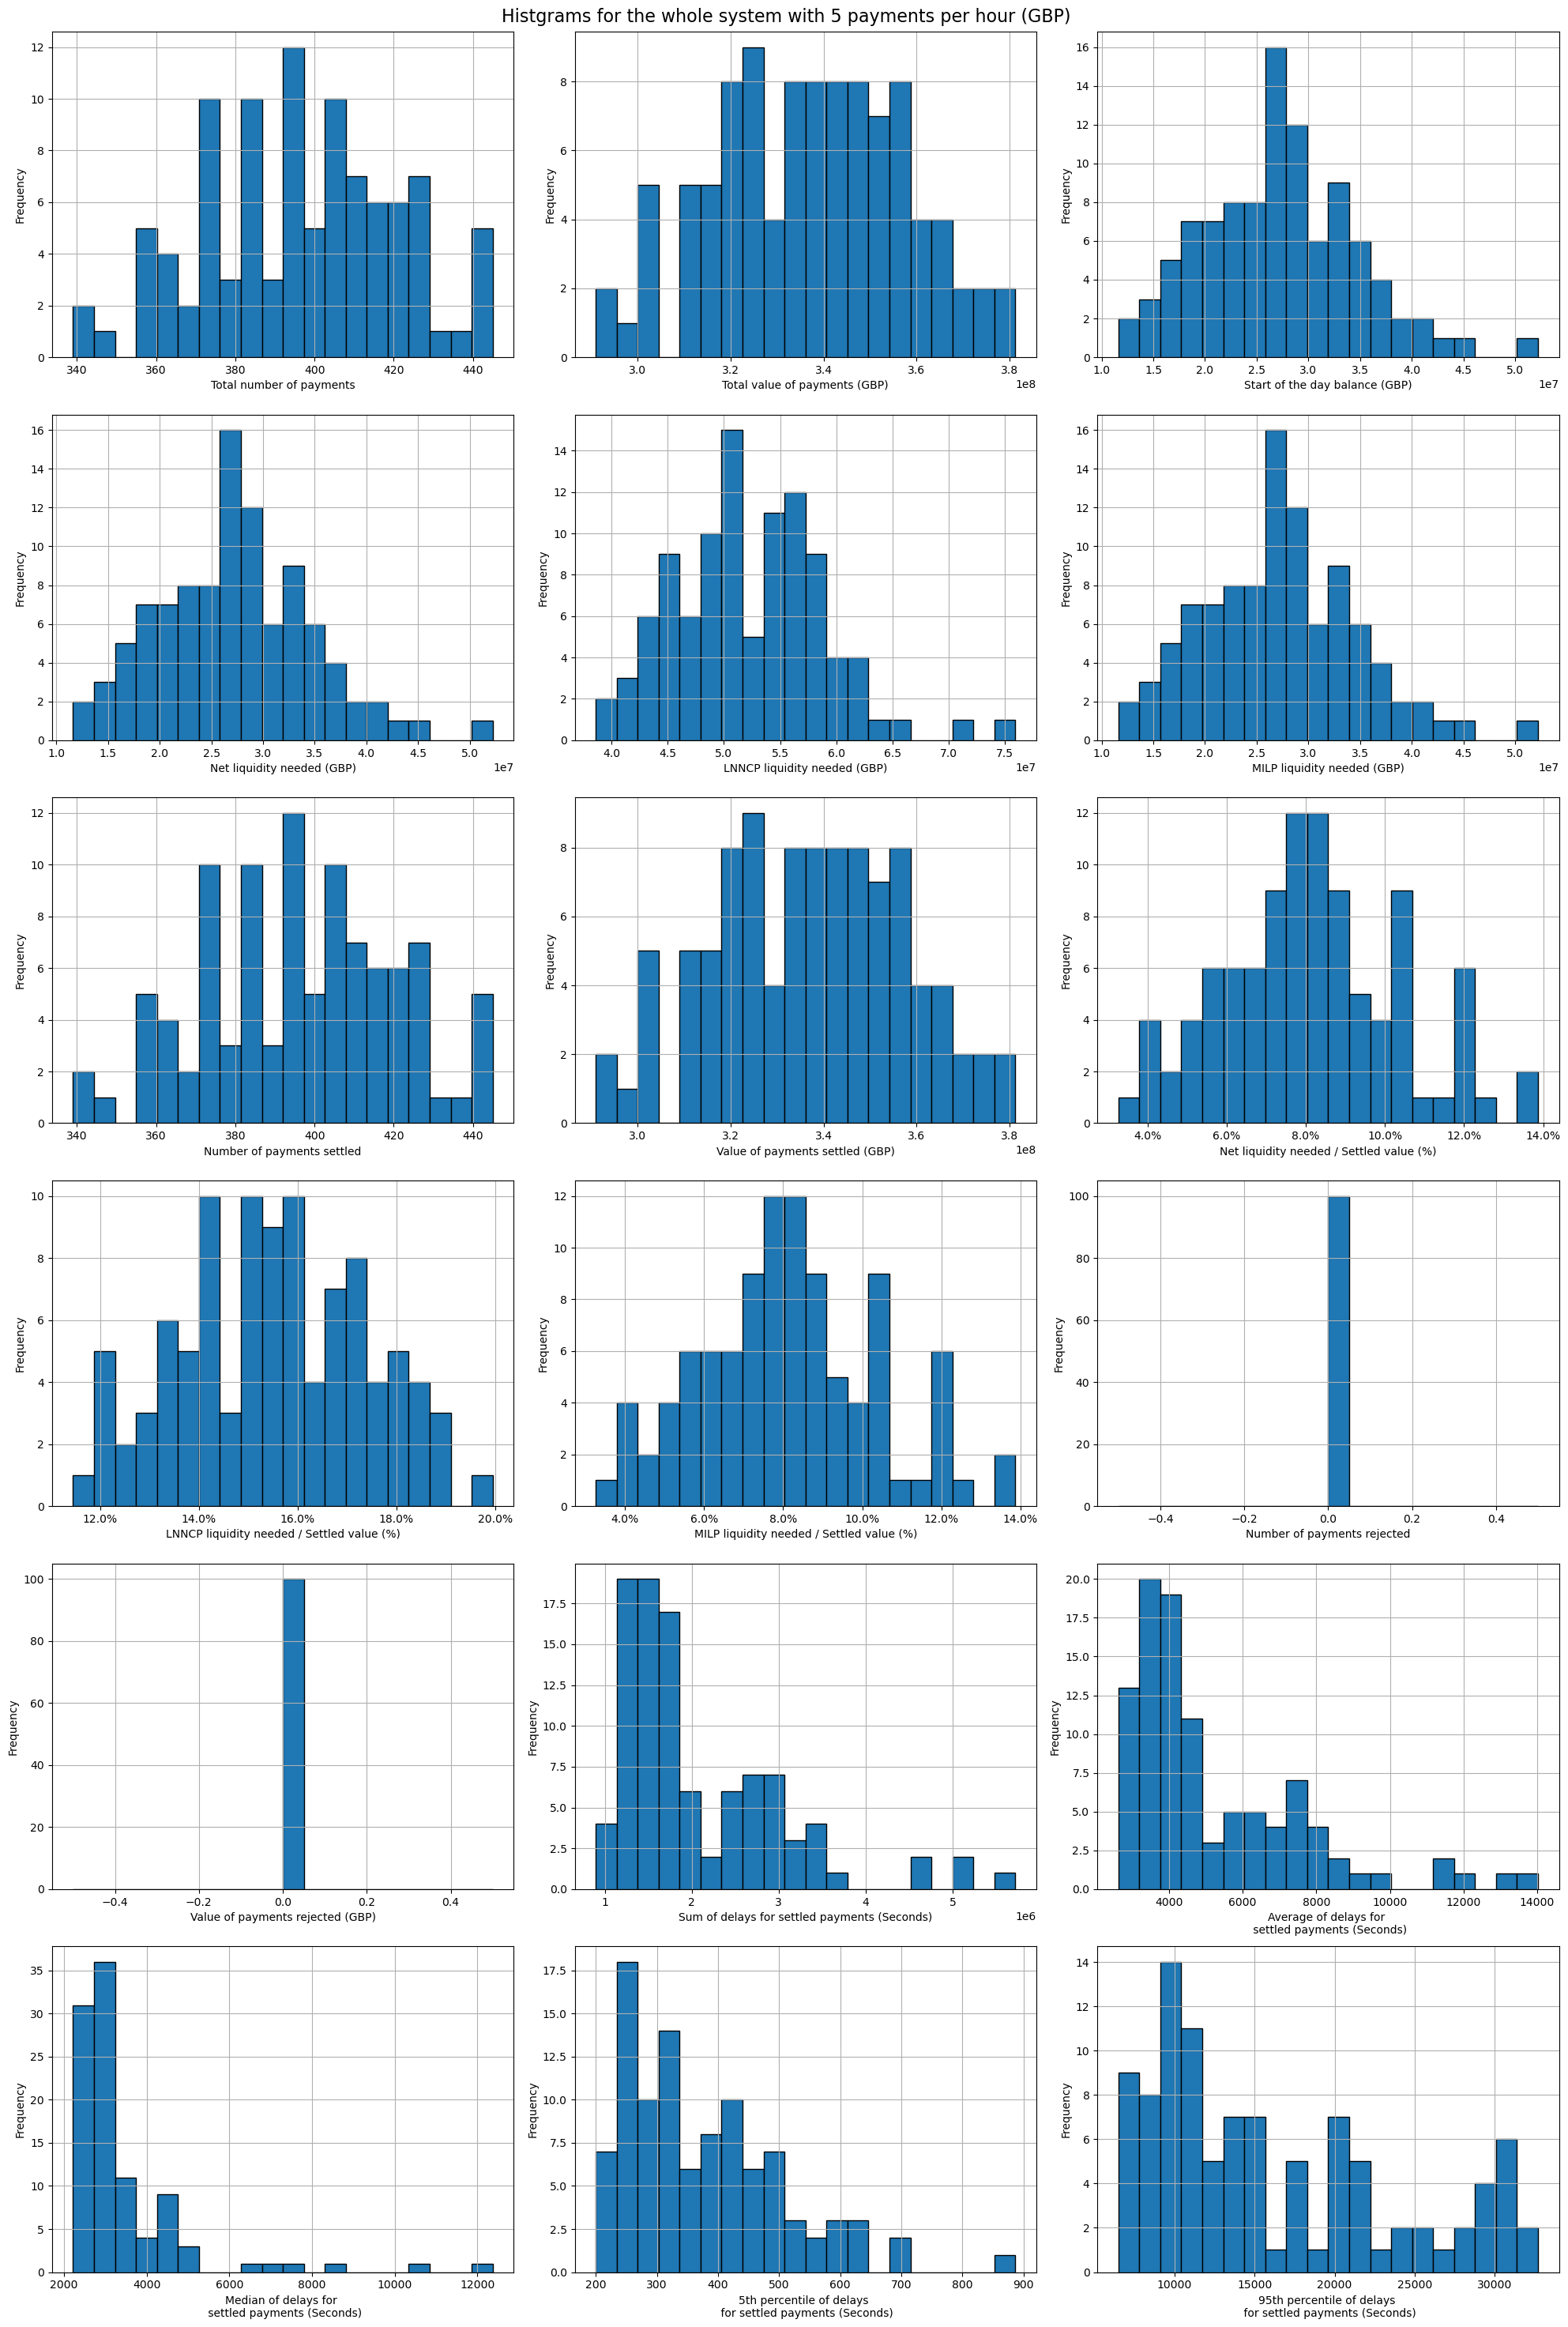

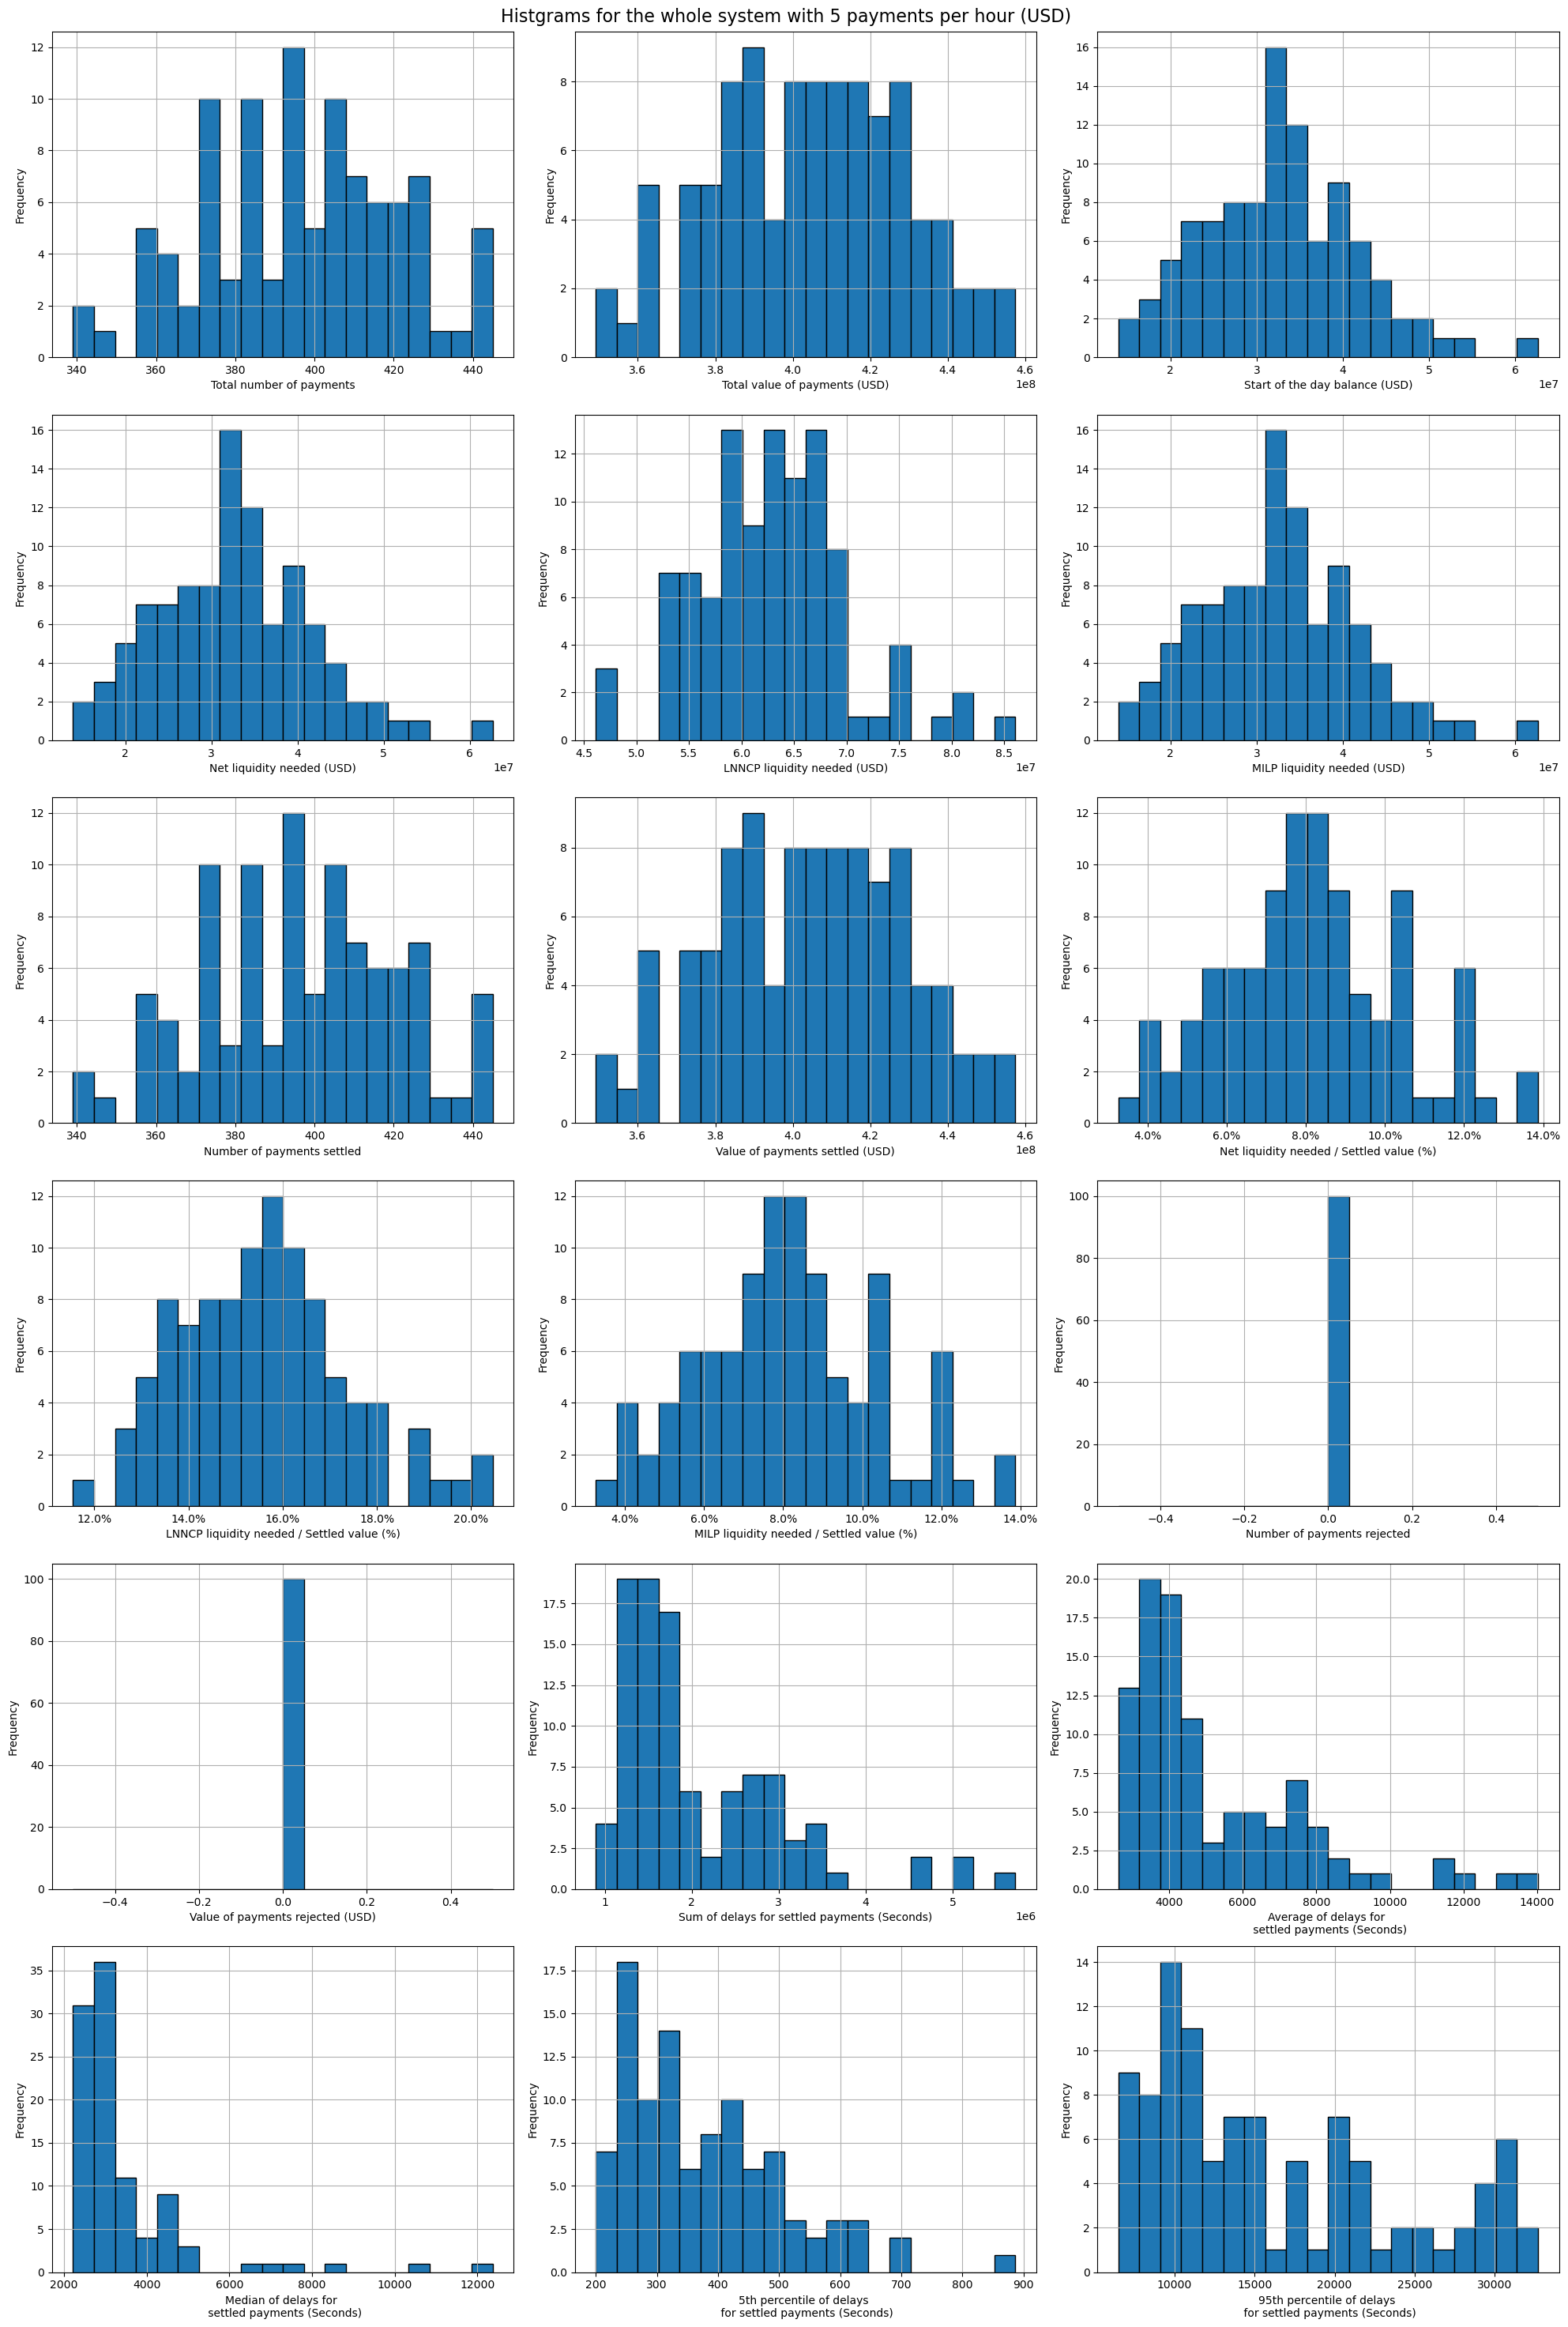

In [14]:
title = fr'Histgrams for the whole system'
distribution_plot(combined_results, 5, title)